In [1]:
# import libraries
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans

# The accident dataset

In [2]:
#read the accident data
dfa=pd.read_csv("dft-road-casualty-statistics-accident-last-5-years.csv")
dfa

accident_index  accident_year accident_reference  \
0       2016010000005           2016          010000005   
1       2016010000006           2016          010000006   
2       2016010000008           2016          010000008   
3       2016010000016           2016          010000016   
4       2016010000018           2016          010000018   
...               ...            ...                ...   
597968  2020991027064           2020          991027064   
597969  2020991029573           2020          991029573   
597970  2020991030297           2020          991030297   
597971  2020991030900           2020          991030900   
597972  2020991032575           2020          991032575   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    519310.0                188730.0  -0.279323  51.584754   
1                    551920.0                174560.0   0.184928  51.449595   
2                    505930.0                183850.0  -0.473837  51.543563   
3                    527770.0                168930.0  -0.164442  51.404958   
4                    510740.0                177230.0  -0.406580  51.483139   
...                       ...                     ...        ...        ...   
597968               343034.0                731654.0  -2.926320  56.473539   
597969               257963.0                658891.0  -4.267565  55.802353   
597970               383664.0                810646.0  -2.271903  57.186317   
597971               277161.0                674852.0  -3.968753  55.950940   
597972               240402.0                681950.0  -4.561040  56.003843   

        police_force  accident_severity  number_of_vehicles  ...  \
0                  1                  3                   2  ...   
1                  1                  3                   1  ...   
2                  1                  3                   1  ...   
3                  1                  3                   1  ...   
4                  1                  3                   2  ...   
...              ...                ...                 ...  ...   
597968            99                  2                   2  ...   
597969            99                  3                   1  ...   
597970            99                  2                   2  ...   
597971            99                  3                   2  ...   
597972            99                  3                   1  ...   

        pedestrian_crossing_physical_facilities light_conditions  \
0                                             0                5   
1                                             0                4   
2                                             0                4   
3                                             0                1   
4                                             0                1   
...                                         ...              ...   
597968                                        0                1   
597969                                        0                1   
597970                                        0                1   
597971                                        0                1   
597972                                        0                1   

        weather_conditions road_surface_conditions  \
0                        1                       1   
1                        1                       1   
2                        1                       1   
3                        1                       1   
4                        1                       1   
...                    ...                     ...   
597968                   1                       1   
597969                   1                       1   
597970                   1                       1   
597971                   1                       1   
597972                   1                       1   

        special_conditions_at_site carriageway_hazards urban_or_ru

In [3]:
#check the data
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597973 entries, 0 to 597972
Data columns (total 36 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               597973 non-null  object 
 1   accident_year                                597973 non-null  int64  
 2   accident_reference                           597973 non-null  object 
 3   location_easting_osgr                        597850 non-null  float64
 4   location_northing_osgr                       597850 non-null  float64
 5   longitude                                    597840 non-null  float64
 6   latitude                                     597840 non-null  float64
 7   police_force                                 597973 non-null  int64  
 8   accident_severity                            597973 non-null  int64  
 9   number_of_vehicles                           597973 non-nul

In [4]:
#check NaN value
missing_val= dfa.isnull().sum().sort_values(ascending=False)
percent_missing = ((missing_val/dfa.isnull().count())*100).sort_values(ascending=False)
missing_df = pd.concat([missing_val,percent_missing], axis=1, keys=['Total', '%'],sort=False)
missing_df[missing_df['Total']>=1]

Total         %
longitude                 133  0.022242
latitude                  133  0.022242
location_easting_osgr     123  0.020569
location_northing_osgr    123  0.020569
speed_limit                37  0.006188

In [5]:
#check duplicates
n_duplicates =dfa.drop(labels=["accident_index"], axis=1).duplicated().sum()
print(f"You might have {n_duplicates} duplicates in your database.")
dfa.shape

You might have 0 duplicates in your database.


(597973, 36)

In [6]:
dfa.accident_index.nunique()

597973

In [7]:
#extract column names of all features
my_column = dfa.drop(labels=["accident_index"], axis=1).columns

#drop duplicates based on my_column
accident_df = dfa.drop_duplicates(subset=my_column)
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597973 entries, 0 to 597972
Data columns (total 36 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               597973 non-null  object 
 1   accident_year                                597973 non-null  int64  
 2   accident_reference                           597973 non-null  object 
 3   location_easting_osgr                        597850 non-null  float64
 4   location_northing_osgr                       597850 non-null  float64
 5   longitude                                    597840 non-null  float64
 6   latitude                                     597840 non-null  float64
 7   police_force                                 597973 non-null  int64  
 8   accident_severity                            597973 non-null  int64  
 9   number_of_vehicles                           597973 non-nul

In [8]:
#replace missing longitude using mean
mean = accident_df['longitude'].mean()
accident_df['longitude'].fillna(mean, inplace=True)

#replacing missing lattitude with mean.
mean = accident_df['latitude'].mean()
accident_df['latitude'].fillna(mean, inplace=True)

In [9]:
#converting time to hours
accident_df['converted_time'] = pd.DatetimeIndex(accident_df['time'])
accident_df['converted_time']= accident_df.converted_time.dt.hour

In [10]:
#drop the orginal time column
accident_df = accident_df.drop('time', axis=1)

In [11]:
median =accident_df['converted_time'].median()
accident_df['converted_time'].fillna(median, inplace=True)

In [12]:
accident_df.converted_time = accident_df.converted_time.astype('int')

In [13]:
#replacing NaN in LSOA_of_Accident_Location,Location_Northing_OSGR, Location_Easting_OSGR with forward fill
accident_df['lsoa_of_accident_location'].fillna(method='ffill').fillna(method='bfill', inplace=True)
accident_df['location_easting_osgr'].fillna(method='ffill').fillna(method='bfill', inplace=True)
accident_df['location_northing_osgr'].fillna(method='ffill').fillna(method='bfill', inplace=True)

In [14]:
#change date to datetime format
accident_df['date'] = pd.to_datetime(accident_df['date'], format='%d/%m/%Y')

In [15]:
#checking value counts
accident_df.light_conditions.value_counts(normalize=True)

 1    0.715837
 4    0.205018
 6    0.051414
 7    0.020650
 5    0.007056
-1    0.000027
Name: light_conditions, dtype: float64

In [16]:
# Change Light_Conditions to proper labels
accident_df.light_conditions = accident_df.light_conditions.replace([1,4,5,6,7,-1], 
                                                      ['Daylight', 
                                                       'Darkness - lights lit', 
                                                       'Darkness - lights unlit', 
                                                       'Darkness - no lighting', 
                                                       'Darkness - lighting unknown', 
                                                       'Daylight'])

accident_df.light_conditions.value_counts(normalize=True)

Daylight                       0.715863
Darkness - lights lit          0.205018
Darkness - no lighting         0.051414
Darkness - lighting unknown    0.020650
Darkness - lights unlit        0.007056
Name: light_conditions, dtype: float64

In [17]:
accident_df.junction_control.value_counts(normalize=True)

 4    0.445998
-1    0.420047
 2    0.109299
 9    0.014706
 3    0.006017
 1    0.003276
 0    0.000656
Name: junction_control, dtype: float64

In [18]:
# Change Junction_Control to proper labels
accident_df.junction_control = accident_df.junction_control.replace([0,1,2,3,4,-1], 
                                                                      ['Not at junction or within 20 metres', 
                                                                       'Authorised person', 'Auto traffic signal', 
                                                                       'Stop sign', 'Give way or uncontrolled', 
                                                                       'Data missing or out of range'])
accident_df.junction_control.value_counts(normalize=True)

Give way or uncontrolled               0.445998
Data missing or out of range           0.420047
Auto traffic signal                    0.109299
9                                      0.014706
Stop sign                              0.006017
Authorised person                      0.003276
Not at junction or within 20 metres    0.000656
Name: junction_control, dtype: float64

In [19]:
accident_df['second_road_class'].value_counts(normalize=True)

 6    0.400630
-1    0.355914
 3    0.100446
 0    0.063428
 4    0.038544
 5    0.035231
 1    0.005162
 2    0.000644
 9    0.000002
Name: second_road_class, dtype: float64

In [20]:
# replace numbers with the right label
accident_df['second_road_class'] = accident_df['second_road_class'].replace([1,2,3,4,5,6,-1], 
                                                                        ['Motorway', 'A(M)', 'A', 'B', 'C', 
                                                                         'Unclassified', 
                                                                         'Not at junction or within 20 meters'])

In [21]:
# Combining A(M) into the motorway category
accident_df['second_road_class'] = accident_df['second_road_class'].replace('A(M)', 'Motorway')
accident_df['second_road_class'].value_counts(normalize=True)

Unclassified                           0.400630
Not at junction or within 20 meters    0.355914
A                                      0.100446
0                                      0.063428
B                                      0.038544
C                                      0.035231
Motorway                               0.005806
9                                      0.000002
Name: second_road_class, dtype: float64

In [22]:
#value counts
accident_df['road_surface_conditions'].value_counts(normalize=True)

 1    0.714746
 2    0.256697
 4    0.012865
 9    0.007785
 3    0.003654
-1    0.002987
 5    0.001266
Name: road_surface_conditions, dtype: float64

In [23]:
#replace with mode
accident_df.road_surface_conditions = accident_df.road_surface_conditions.replace([1,2,3,4,5,-1], 
                                                                                    ['Dry', 
                                                                                     'Wet or damp', 
                                                                                     'Snow', 
                                                                                     'Frost or ice', 
                                                                                     'Flood over 3cm. deep', 
                                                                                     'Dry'])
accident_df.road_surface_conditions.value_counts(normalize=True)

Dry                     0.717733
Wet or damp             0.256697
Frost or ice            0.012865
9                       0.007785
Snow                    0.003654
Flood over 3cm. deep    0.001266
Name: road_surface_conditions, dtype: float64

In [24]:
accident_df.junction_detail.value_counts(normalize=True)

 0     0.417621
 3     0.295834
 6     0.094682
 1     0.081900
 9     0.038990
 8     0.024988
 5     0.014225
 2     0.012981
 7     0.011432
 99    0.007336
-1     0.000012
Name: junction_detail, dtype: float64

In [25]:
# Change junction_detail with labels
# Rather than dropping missing data(-1), it was added to the mode (Not at junction or within 20 meters)
accident_df.junction_detail = accident_df.junction_detail.replace([0,1,2,3,5,6,7,8,9,-1], 
                                                                    ['Not at junction or within 20 meters', 
                                                                     'Roundabout', 'Mini-roundabout', 
                                                                     'T or staggered junction', 'Slip road', 
                                                                     'Crossroads', 
                                                                     'More than 4 arms (not roundabout)', 
                                                                     'Private drive or entrance', 'Other junction', 
                                                                     'Not at junction or within 20 meters'])
accident_df.junction_detail.value_counts(normalize=True)

Not at junction or within 20 meters    0.417633
T or staggered junction                0.295834
Crossroads                             0.094682
Roundabout                             0.081900
Other junction                         0.038990
Private drive or entrance              0.024988
Slip road                              0.014225
Mini-roundabout                        0.012981
More than 4 arms (not roundabout)      0.011432
99                                     0.007336
Name: junction_detail, dtype: float64

In [26]:
accident_df['speed_limit'].value_counts(normalize=True)

 30.0    0.601417
 60.0    0.127798
 40.0    0.083925
 20.0    0.083576
 70.0    0.062114
 50.0    0.041016
-1.0     0.000154
Name: speed_limit, dtype: float64

In [27]:
#added to the mode (30mph)
accident_df.speed_limit = accident_df.speed_limit.replace([20,30,40,50,60,70,-1], 
                                                                    ['20MPH', '30MPH', '40MPH', '50MPH','60MPH','70MPH','30MPH'])
accident_df.speed_limit.value_counts(normalize=True)

30MPH    0.601571
60MPH    0.127798
40MPH    0.083925
20MPH    0.083576
70MPH    0.062114
50MPH    0.041016
Name: speed_limit, dtype: float64

In [28]:
accident_df['urban_or_rural_area'].value_counts(normalize=True)

 1    0.668544
 2    0.331264
 3    0.000191
-1    0.000002
Name: urban_or_rural_area, dtype: float64

In [29]:
accident_df.urban_or_rural_area = accident_df.urban_or_rural_area.replace([1,2,3], 
                                                                    ['Urban', 'Rural', 'Urban'])
accident_df.urban_or_rural_area.value_counts(normalize=True)

Urban    0.668734
Rural    0.331264
-1       0.000002
Name: urban_or_rural_area, dtype: float64

In [30]:
accident_df['day_of_week'].value_counts(normalize=True)

6    0.163536
5    0.152902
4    0.150385
3    0.147834
2    0.141088
7    0.132123
1    0.112132
Name: day_of_week, dtype: float64

In [31]:
#converted to proper labels
accident_df.day_of_week = accident_df.day_of_week.replace([1,2,3,4,5,6,7], 
                                                                    ['Sunday', 'Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday'])
accident_df['day_of_week'].value_counts(normalize=True)

Friday       0.163536
Thursday     0.152902
Wednesday    0.150385
Tuesday      0.147834
Monday       0.141088
Saturday     0.132123
Sunday       0.112132
Name: day_of_week, dtype: float64

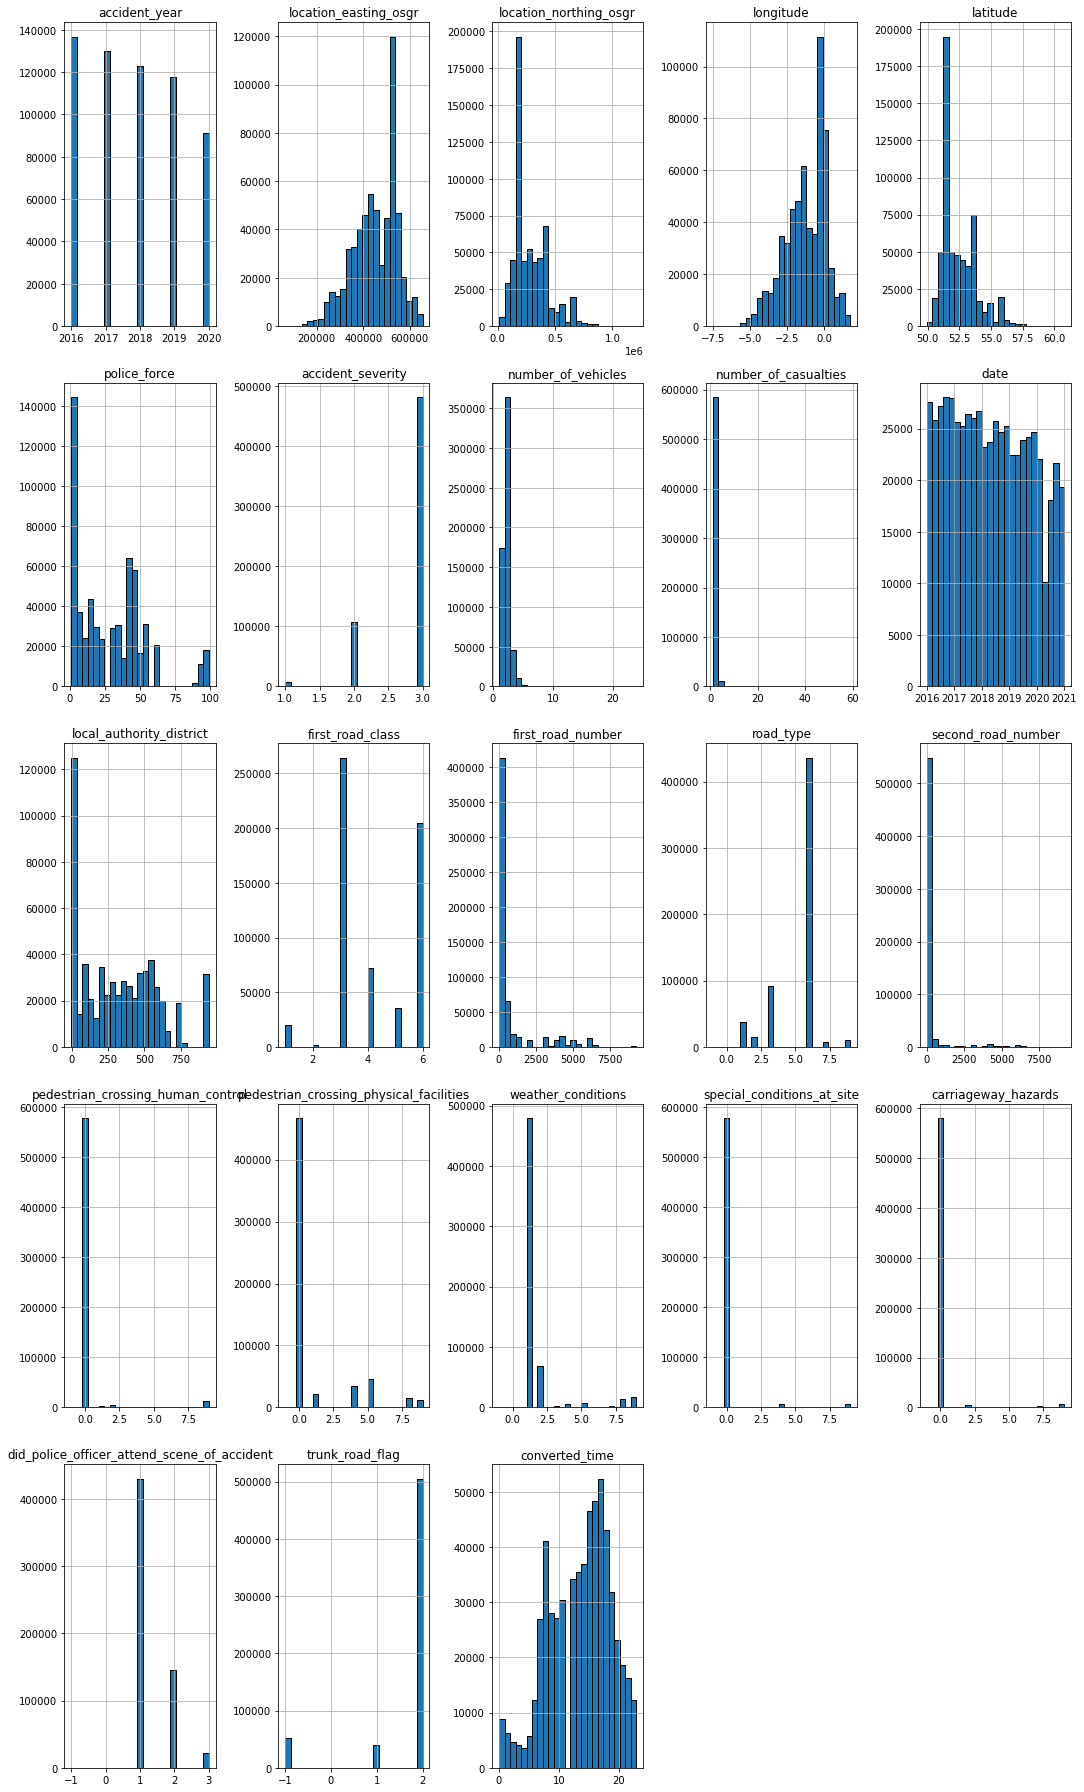

In [32]:
#view the distribution of the variables
accident_df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

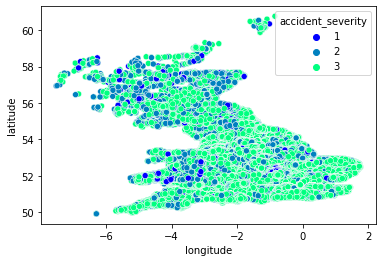

In [33]:
#visualize the accident serveity using scatter plot
#1=fatal, 2=serious, 3=slight
sns.scatterplot(data=accident_df, x = "longitude", y = "latitude", hue = "accident_severity", palette = "winter")
plt.show()

In [34]:
accident_df['accident_severity'].mode()

0    3
dtype: int64

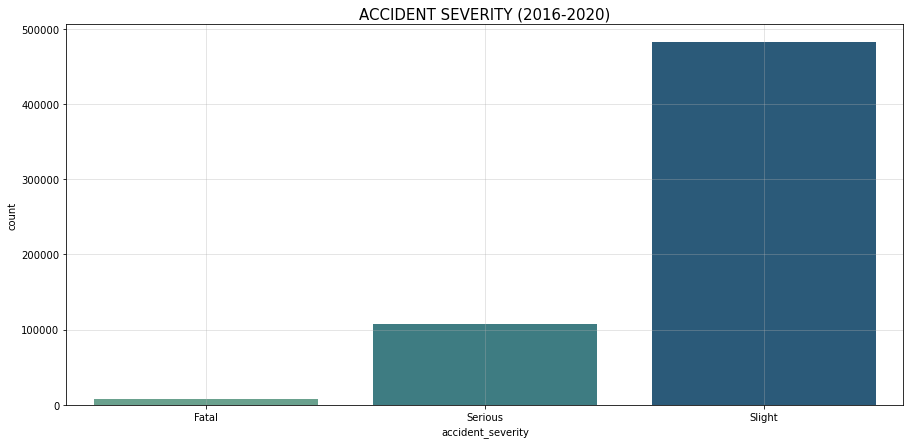

In [35]:
plt.figure(figsize=(15,7))
ax=sns.countplot(accident_df['accident_severity'], palette = "crest")
plt.title('ACCIDENT SEVERITY (2016-2020)', fontsize=15)
ax.set_xticklabels(['Fatal','Serious','Slight'])
plt.grid(alpha=0.4)
plt.savefig("accident_severity.png", dpi=600)

In [36]:
accident_df['accident_severity'].value_counts()/accident_df.shape[0]*100

3    80.563002
2    18.083927
1     1.353071
Name: accident_severity, dtype: float64

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar

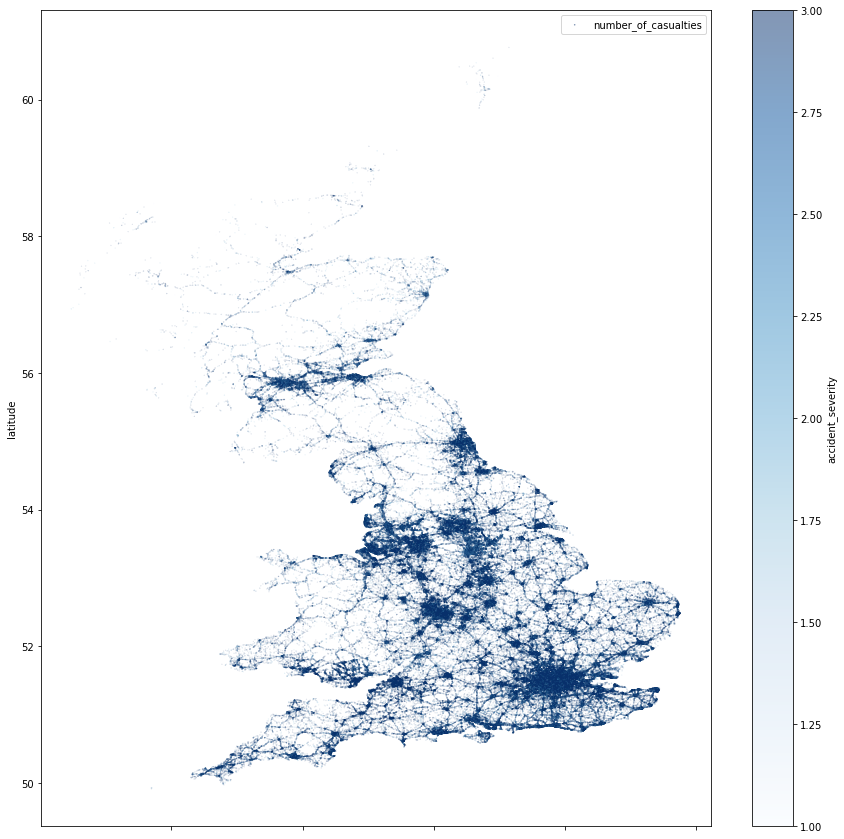

In [38]:
accident_df.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.5,
             s = accident_df["number_of_casualties"]/100, label = "number_of_casualties", figsize=(15,15),
             c = "accident_severity", cmap = plt.get_cmap("Blues"), colorbar= True
             )


plt.legend()

#save the fig
plt.savefig("overall_distribution.png", dpi=600)

<AxesSubplot:>

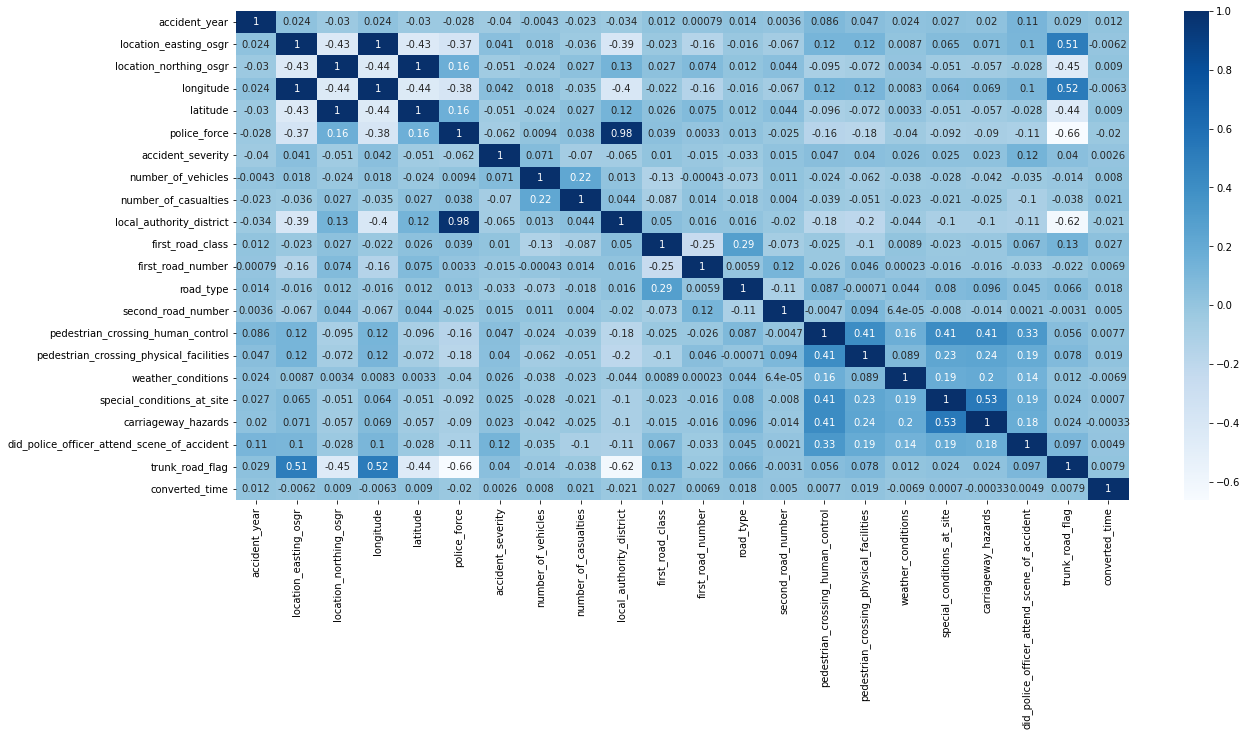

In [39]:
#check the correlation matrix
corr =  accident_df.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr, annot = True,cmap="Blues")

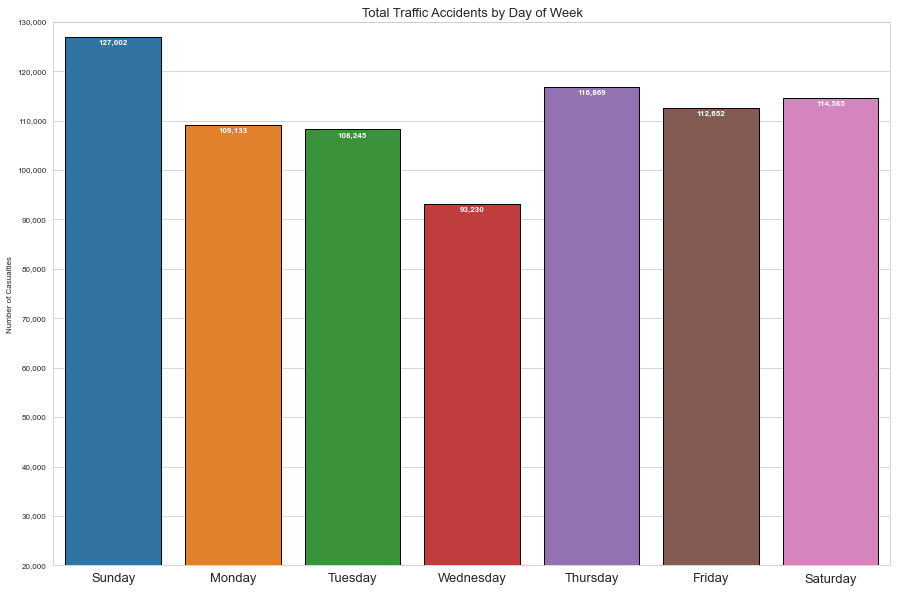

In [40]:
accidents_by_week = accident_df.groupby(['day_of_week']).sum()['number_of_casualties'].to_frame().reset_index()
accidents_by_date = accident_df.groupby(['date', 
                                        'day_of_week']).sum()['number_of_casualties'].to_frame().reset_index()
accidents_by_hour = accident_df.groupby(['day_of_week',
                                        'converted_time']).sum()['number_of_casualties'].to_frame().reset_index()
accidents_by_hour_pivot = accidents_by_hour.pivot_table(values=['number_of_casualties'], 
                                                        index=['converted_time'], 
                                                        columns=['day_of_week'])
accidents_by_hour_pivot.columns = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

# Plot bars for Number of Casualties by Day of Week
 
plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
b = sns.barplot(x='day_of_week', y='number_of_casualties', data=accidents_by_week,
                palette='tab10', linewidth=1, edgecolor='black')

# Define x_axis for xticks
x_axis = np.arange(0,7,1)

# Calculate upper bound of y-axis
y_max = max(accidents_by_week['number_of_casualties'])
# round the upper bound of y-axis up to nearest thousand
y_max -= y_max % -1000
step = 10000
y_axis = np.arange(20000, y_max+step, step)
# format y-ticks as comma separated
y_axis_fmt = ["{:,.0f}".format(y) for y in y_axis]
# set y-axis limits
plt.ylim(min(y_axis), max(y_axis))

#plt.tick_params(axis='y', which='major', direction='out', length=2, color='gray')
plt.xticks(x_axis, ('Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'), fontsize=13)
plt.yticks(y_axis, y_axis_fmt, fontsize=8)
plt.xlabel('')
plt.ylabel('Number of Casualties', fontsize=8)

# Add Data Labels for bar values
ax = b.axes
for p in ax.patches:
    ax.annotate(s="{:,.0f}".format(p.get_height()), xy=((p.get_x() + p.get_width() / 2., p.get_height()-1500)),
                ha='center', va='center', color='white', xytext=(0, 2), 
                textcoords='offset points', weight='bold', fontsize=8)  

plt.title('Total Traffic Accidents by Day of Week', fontsize=13)
plt.show()

In [41]:
def Percentage(total_count,attribute_count):
    return float(attribute_count)/float(total_count)*100

In [42]:
#calculate the percentages of accidents happen in each day of a week
acc_mon=float(len(dfa.loc[dfa.day_of_week==2,:]))/len(dfa)*100
acc_tue=float(len(dfa.loc[dfa.day_of_week==3,:]))/len(accident_df)*100
acc_wed=float(len(dfa.loc[dfa.day_of_week==4,:]))/len(dfa)*100
acc_thur=float(len(dfa.loc[dfa.day_of_week==5,:]))/len(dfa)*100
acc_fri=float(len(dfa.loc[dfa.day_of_week==6,:]))/len(dfa)*100
acc_sat=float(len(dfa.loc[dfa.day_of_week==7,:]))/len(dfa)*100
acc_sun=float(len(dfa.loc[dfa.day_of_week==1,:]))/len(dfa)*100

print ('% of Accident happening on Mondays',acc_mon);
print ('% of Accident happening on Tuesdays',acc_tue);
print ('% of Accidents happening on Wednesdays',acc_wed);
print ('% of Accidents happening on Thursdays',acc_thur);
print ('% of Accidents happening on Fridays',acc_fri);
print ('% of Accidents happening on Saturdays',acc_sat);
print ('% of Accidents happening on Sundays',acc_sun);

% of Accident happening on Mondays 14.1088310007308
% of Accident happening on Tuesdays 14.783443399618376
% of Accidents happening on Wednesdays 15.03847163667925
% of Accidents happening on Thursdays 15.290155241122926
% of Accidents happening on Fridays 16.35358118175904
% of Accidents happening on Saturdays 13.212302227692554
% of Accidents happening on Sundays 11.213215312397049


In [43]:
#combining A(M) into the motorway category
accident_df['first_road_class'].replace('A(M)', 'Motorway', inplace=True)
accident_df['second_road_class'].replace('A(M)', 'Motorway', inplace=True)

In [44]:
accident_df['first_road_class'].value_counts(normalize=True)

3    0.442095
6    0.342969
4    0.120116
5    0.058932
1    0.033189
2    0.002699
Name: first_road_class, dtype: float64

In [45]:
accident_df['first_road_class'] = accident_df['first_road_class'].replace([1,2,3,4,5,6], 
                                                                        ['Motorway', 'A(M)', 'A', 'B', 'C', 
                                                                         'Unclassified', 
                                                                        ])

In [46]:
#specify the the accident severity label
accident_df['accident_severity'] = accident_df['accident_severity'].replace([1,2,3], ['Fatal', 'Serious', 'Slight'])

In [47]:
#creating a pivot table of accident proportions by road type
road_accident = accident_df.groupby('accident_severity')['first_road_class'].value_counts(normalize=True).unstack()
road_accident = road_accident[['A', 'Unclassified', 'B', 'C', 'Motorway']].sort_index(ascending=False)

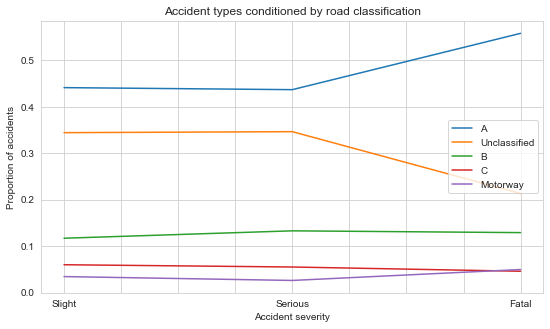

In [48]:
road_accident.plot(figsize=(9,5), kind='line')
plt.title('Accident types conditioned by road classification')
plt.xlabel('Accident severity')
plt.ylabel('Proportion of accidents')
plt.xticks(rotation=0)
plt.legend();

In [49]:
accident_df.road_type.value_counts(normalize=True)

 6    0.729247
 3    0.153395
 1    0.062402
 2    0.024247
 9    0.017546
 7    0.013161
-1    0.000002
Name: road_type, dtype: float64

In [50]:
#change into proper lables for further analysis
accident_df.road_type = accident_df.road_type.replace([1,2,3,6,7,9], 
                               ['Roundabout', 'One way street', 'Dual carriageway', 'Single carriageway', 
                                'Slip road', 'Unknown'])
accident_df.road_type.value_counts(normalize=True)

Single carriageway    0.729247
Dual carriageway      0.153395
Roundabout            0.062402
One way street        0.024247
Unknown               0.017546
Slip road             0.013161
-1                    0.000002
Name: road_type, dtype: float64

In [51]:
#pivot table with accident proportions broken down by road type
accident_by_road_type = accident_df.groupby('accident_severity')['road_type'].value_counts(normalize=True).unstack()
accident_by_road_type = accident_by_road_type[['Single carriageway', 'Dual carriageway', 'Roundabout', 'One way street', 'Slip road']].sort_index(ascending=False)
accident_by_road_type

road_type          Single carriageway  Dual carriageway  Roundabout  \
accident_severity                                                     
Slight                       0.717807          0.156228    0.067033   
Serious                      0.777819          0.137538    0.045202   
Fatal                        0.761216          0.196638    0.016562   

road_type          One way street  Slip road  
accident_severity                             
Slight                   0.025279   0.014005  
Serious                  0.020659   0.009617  
Fatal                    0.010753   0.010258

In [52]:
#return a table with proportion of accidents based on severity
def portion_of_accident_severity(col):
    return accident_df.groupby(col)['accident_severity'].value_counts(normalize=True).unstack()

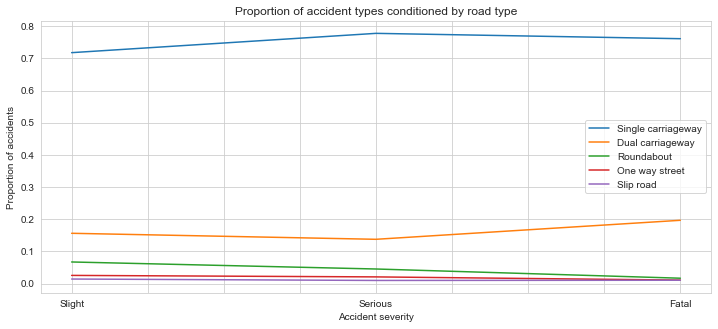

In [53]:
accident_by_road_type.plot(figsize=(12,5), kind='line')
plt.title('Proportion of accident types conditioned by road type')
plt.xlabel('Accident severity')
plt.ylabel('Proportion of accidents')
plt.xticks(rotation=0)
plt.legend();
plt.savefig("road_type.png", dpi=600)

In [54]:
def stacked_severity_plot(col, title='Proportion of accidents by severity', figsize=(10,5)):
    """Plots a bar chart of the proportions of the specified column for each accident severity category"""
    accident_df.groupby('accident_severity')[col].value_counts(normalize=True).unstack().sort_index(ascending=False).plot(figsize=figsize, kind='line')
    plt.title(title)
    plt.xlabel('Accident severity')
    plt.ylabel('Proportion of accidents')
    plt.xticks(rotation=0)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

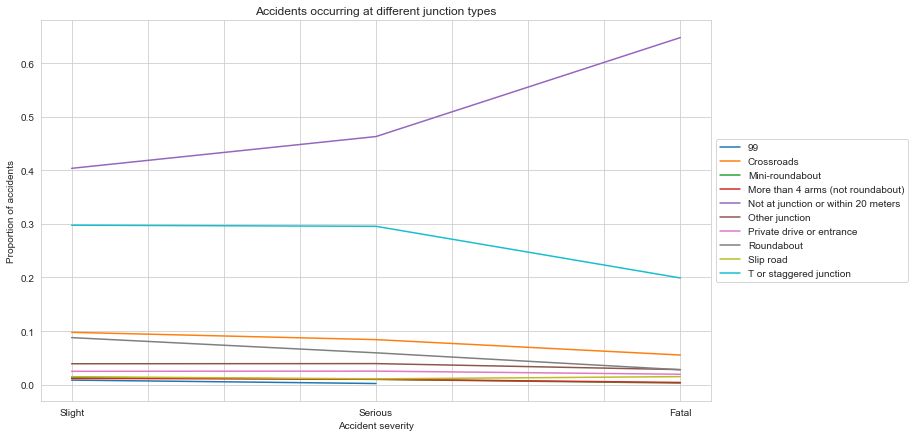

In [55]:
stacked_severity_plot('junction_detail', figsize=(12,7), title='Accidents occurring at different junction types')

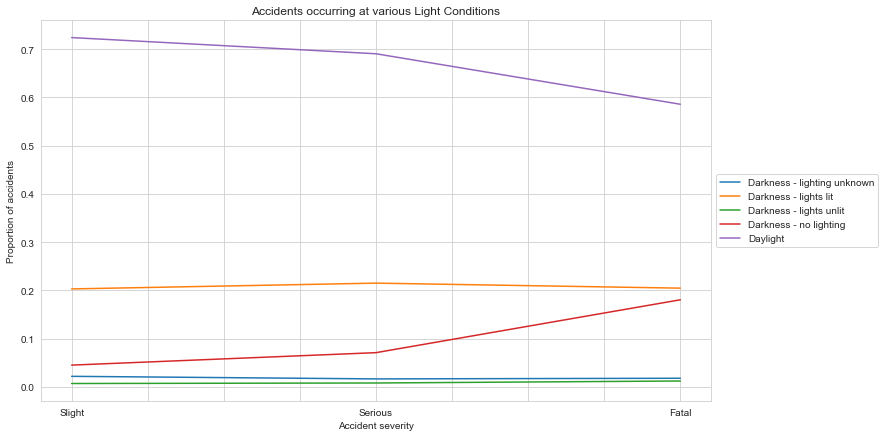

In [56]:
stacked_severity_plot('light_conditions', figsize=(12,7), title='Accidents occurring at various Light Conditions')
plt.savefig("light_condition.png", dpi=600)

In [57]:
accident_df.weather_conditions.value_counts(normalize=True)

 1    0.801402
 2    0.114483
 9    0.029981
 8    0.022063
 5    0.011472
 4    0.010482
 7    0.004552
 3    0.004348
 6    0.001159
-1    0.000057
Name: weather_conditions, dtype: float64

In [58]:
#cover into proper labels
accident_df.weather_conditions = accident_df.weather_conditions.replace([1,2,3,4,5,6,7,8,9], 
                               ['Fine no high winds', 'Raining no high winds', 'Snowing no high winds', 'Fine + high winds', 
                                'Raining + high winds','Snowing + high winds','Fog or mist','other', 'Unknown'])
accident_df.weather_conditions.value_counts(normalize=True)

Fine no high winds       0.801402
Raining no high winds    0.114483
Unknown                  0.029981
other                    0.022063
Raining + high winds     0.011472
Fine + high winds        0.010482
Fog or mist              0.004552
Snowing no high winds    0.004348
Snowing + high winds     0.001159
-1                       0.000057
Name: weather_conditions, dtype: float64

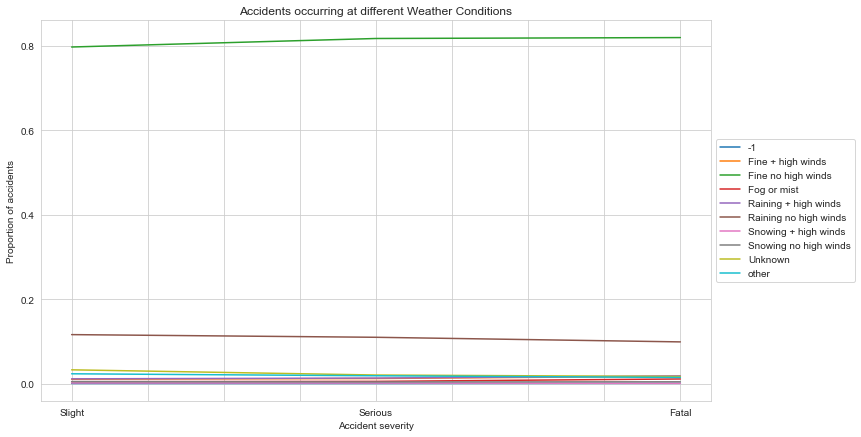

In [59]:
stacked_severity_plot('weather_conditions', figsize=(12,7), title='Accidents occurring at different Weather Conditions')
plt.savefig("weather_condition.png", dpi=600)

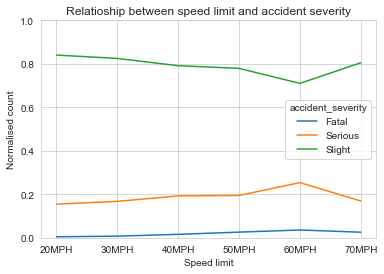

In [60]:
#visualize the relationship between speed limit and accident severity
pd.crosstab(accident_df['speed_limit'], 
            accident_df['accident_severity'], 
            normalize="index").plot(ylim=[0,1])

plt.title("Relatioship between speed limit and accident severity");
plt.xlabel("Speed limit");
plt.ylabel("Normalised count");

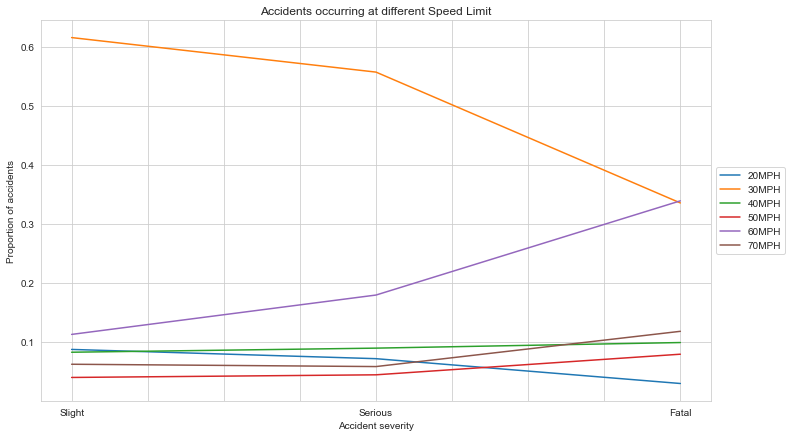

In [61]:
stacked_severity_plot('speed_limit', figsize=(12,7), title='Accidents occurring at different Speed Limit')
plt.savefig("speed_limit.png", dpi=600)

# The vehicle dataset

In [62]:
#read the second dataset
dfv=pd.read_csv("dft-road-casualty-statistics-vehicle-last-5-years.csv")
dfv

accident_index  accident_year accident_reference  vehicle_reference  \
0        2016010000005           2016          010000005                  1   
1        2016010000005           2016          010000005                  2   
2        2016010000006           2016          010000006                  1   
3        2016010000008           2016          010000008                  1   
4        2016010000016           2016          010000016                  1   
...                ...            ...                ...                ...   
1101586  2020991030297           2020          991030297                  1   
1101587  2020991030297           2020          991030297                  2   
1101588  2020991030900           2020          991030900                  1   
1101589  2020991030900           2020          991030900                  2   
1101590  2020991032575           2020          991032575                  1   

         vehicle_type  towing_and_articulation  vehicle_manoeuvre  \
0                   8                        0                  6   
1                   2                        0                 18   
2                   9                        0                 18   
3                   9                        0                 18   
4                  11                        0                 18   
...               ...                      ...                ...   
1101586             9                        0                  7   
1101587             5                        0                 16   
1101588             9                        0                  7   
1101589             1                        0                 18   
1101590             9                        0                  1   

         vehicle_direction_from  vehicle_direction_to  \
0                             3                     7   
1                             7                     3   
2                             5                     1   
3                             1                     8   
4                             5                     1   
...                         ...                   ...   
1101586                       8                     2   
1101587                       6                     2   
1101588                       8                     2   
1101589                       6                     2   
1101590                       8                     4   

         vehicle_location_restricted_lane  ...  journey_purpose_of_driver  \
0                                       0  ...                          1   
1                                       0  ...                          6   
2                                       0  ...                          6   
3                                       0  ...                          6   
4                                       0  ...                          1   
...                                   ...  ...                        ...   
1101586                                 0  ...                          1   
1101587                                 0  ...                          5   
1101588                                 0  ...                          6   
1101589                                 4  ...                          6   
1101590                                 0  ...                          6   

         sex_of_driver  age_of_driver  age_band_of_driver  engine_capacity_cc  \
0                    1             51                   8                  -1   
1                    1             23                   5                 124   
2                    2             36                   7                1461   
3                    1             24                   5                1390   
4                    1             55                   8                6692   
...                ...            ...                 ...                 ...   
1101586              1             57                

In [63]:
#check it
dfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101591 entries, 0 to 1101590
Data columns (total 27 columns):
 #   Column                            Non-Null Count    Dtype 
---  ------                            --------------    ----- 
 0   accident_index                    1101591 non-null  object
 1   accident_year                     1101591 non-null  int64 
 2   accident_reference                1101591 non-null  object
 3   vehicle_reference                 1101591 non-null  int64 
 4   vehicle_type                      1101591 non-null  int64 
 5   towing_and_articulation           1101591 non-null  int64 
 6   vehicle_manoeuvre                 1101591 non-null  int64 
 7   vehicle_direction_from            1101591 non-null  int64 
 8   vehicle_direction_to              1101591 non-null  int64 
 9   vehicle_location_restricted_lane  1101591 non-null  int64 
 10  junction_location                 1101591 non-null  int64 
 11  skidding_and_overturning          1101591 non-null

In [64]:
missing_val= dfv.isnull().sum().sort_values(ascending=False)
percent_missing = ((missing_val/dfv.isnull().count())*100).sort_values(ascending=False)
missing_df = pd.concat([missing_val,percent_missing], axis=1, keys=['Total', 'Percent'],sort=False)
missing_df[missing_df['Total']>=1]

Empty DataFrame
Columns: [Total, Percent]
Index: []

In [65]:
dfv.drop_duplicates(subset=['accident_index'],inplace=True)

In [66]:
dfv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597975 entries, 0 to 1101590
Data columns (total 27 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   accident_index                    597975 non-null  object
 1   accident_year                     597975 non-null  int64 
 2   accident_reference                597975 non-null  object
 3   vehicle_reference                 597975 non-null  int64 
 4   vehicle_type                      597975 non-null  int64 
 5   towing_and_articulation           597975 non-null  int64 
 6   vehicle_manoeuvre                 597975 non-null  int64 
 7   vehicle_direction_from            597975 non-null  int64 
 8   vehicle_direction_to              597975 non-null  int64 
 9   vehicle_location_restricted_lane  597975 non-null  int64 
 10  junction_location                 597975 non-null  int64 
 11  skidding_and_overturning          597975 non-null  int64 
 12  h

In [67]:
#check duplicates
n_duplicates =dfv.drop(labels=["accident_index"], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 0 duplicates in your database.


In [68]:
#  Extract column names of all features
columns_to_consider = dfv.drop(labels=["accident_index"], axis=1).columns

# Drop duplicates based on 'columns_to_consider'
vehicle_df = dfv.drop_duplicates(subset=columns_to_consider, keep='first')
vehicle_df.shape

(597975, 27)

<AxesSubplot:>

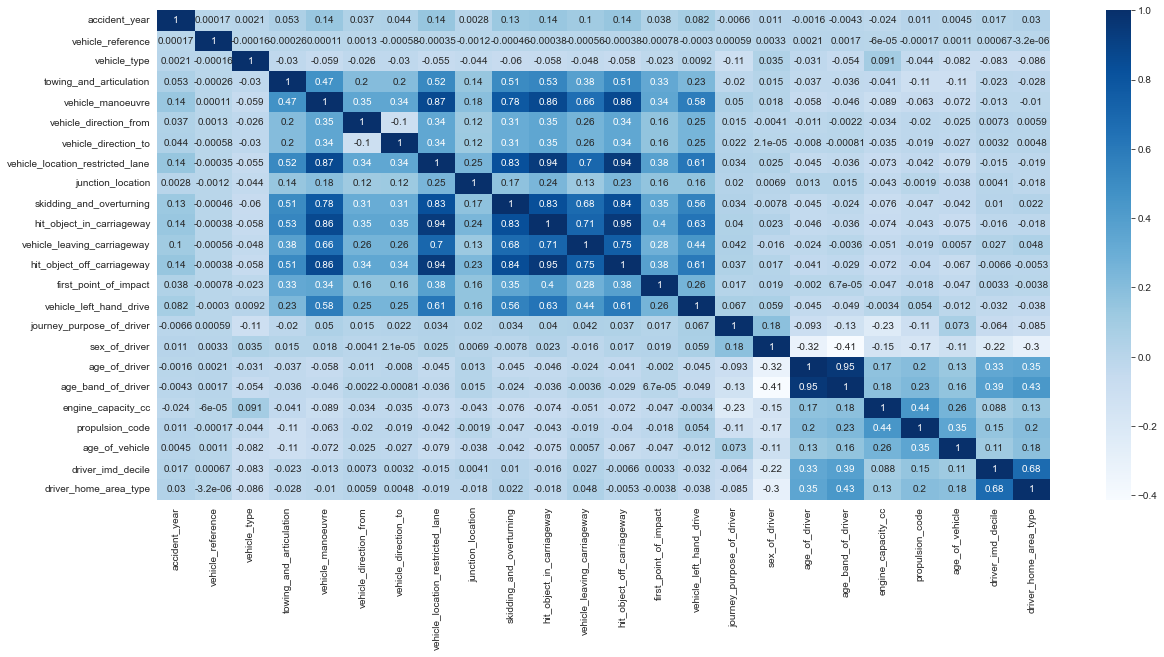

In [69]:
#check the correlation matrix
corr =  vehicle_df.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr, annot = True,cmap="Blues")

In [70]:
vehicle_df['engine_capacity_cc'].replace(-1, np.NaN, inplace=True)
vehicle_df['engine_capacity_cc'].describe()

count    470653.000000
mean       1852.513278
std        1582.226426
min           1.000000
25%        1242.000000
50%        1596.000000
75%        1995.000000
max       91000.000000
Name: engine_capacity_cc, dtype: float64

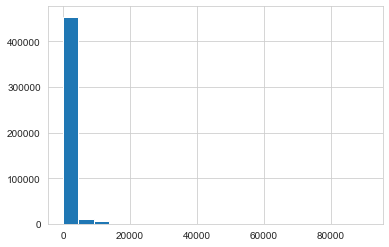

In [71]:
vehicle_df['engine_capacity_cc'].hist(bins=20)
plt.show()

In [72]:
vehicle_df['engine_capacity_cc'].describe()

count    470653.000000
mean       1852.513278
std        1582.226426
min           1.000000
25%        1242.000000
50%        1596.000000
75%        1995.000000
max       91000.000000
Name: engine_capacity_cc, dtype: float64

In [73]:
# Replacing uknown values (-1) as NaN
vehicle_df['age_of_vehicle'].replace(-1, np.NaN, inplace=True)
vehicle_df['age_of_driver'].replace(-1, np.NaN, inplace=True)
vehicle_df['vehicle_left_hand_drive'].replace(-1, np.NaN, inplace=True)
vehicle_df['propulsion_code'].replace(-1, np.NaN, inplace=True)
vehicle_df['journey_purpose_of_driver'].replace(-1, np.NaN, inplace=True)

In [74]:
# Replacing NaN values as median
vehicle_df['age_of_vehicle'].fillna(vehicle_df['age_of_vehicle'].median(), inplace=True)
vehicle_df['age_of_driver'].fillna(vehicle_df['age_of_driver'].median(), inplace=True)
vehicle_df['vehicle_left_hand_drive'].fillna(vehicle_df['vehicle_left_hand_drive'].mode(), inplace=True)
vehicle_df['propulsion_code'].fillna(vehicle_df['propulsion_code'].mode(), inplace=True)
vehicle_df['journey_purpose_of_driver'].fillna(vehicle_df['journey_purpose_of_driver'].mode(), inplace=True)

In [75]:
vehicle_df.journey_purpose_of_driver.value_counts(normalize=True)

6.0    0.616399
1.0    0.151831
2.0    0.108662
5.0    0.108525
3.0    0.011817
4.0    0.002767
Name: journey_purpose_of_driver, dtype: float64

In [76]:
vehicle_df.journey_purpose_of_driver = vehicle_df.journey_purpose_of_driver.replace([1,2,3,4,5,6], 
                                                                                    ['Journey as part of work', 
                                                                                     'Commuting to/from work', 
                                                                                     'Taking pupil to/from school', 
                                                                                     'pupil riding to/from school', 
                                                                                     'Other', 
                                                                                     'Not known'])
vehicle_df.journey_purpose_of_driver.value_counts(normalize=True)

Not known                      0.616399
Journey as part of work        0.151831
Commuting to/from work         0.108662
Other                          0.108525
Taking pupil to/from school    0.011817
pupil riding to/from school    0.002767
Name: journey_purpose_of_driver, dtype: float64

In [77]:
vehicle_df['vehicle_left_hand_drive']= vehicle_df['vehicle_left_hand_drive'].replace([1,2],['No','Yes'])

vehicle_df['vehicle_left_hand_drive'].value_counts(normalize=True)

No     0.965552
9.0    0.027170
Yes    0.007279
Name: vehicle_left_hand_drive, dtype: float64

In [78]:
vehicle_df['propulsion_code'].value_counts(normalize=True)

1.0     0.560054
2.0     0.414522
8.0     0.022153
3.0     0.001816
7.0     0.000693
12.0    0.000392
5.0     0.000214
6.0     0.000153
4.0     0.000004
Name: propulsion_code, dtype: float64

In [79]:
vehicle_df.propulsion_code = vehicle_df.propulsion_code.replace([1,2,3,4,5,6,7,8,9,10,11,12,'M'], 
                                                                                    ['Petrol','Heavy Oil', 'Electric', 'Steam','Gas', 'Petrol/Gas(LPG)',
                                                                                     'Gas/Bi-fuel', 'Hybrid electric', 'Gas Diesel','New fuel technology', 'Fuel cells', 'Electric Diesel', 'Undefined'])
vehicle_df['propulsion_code'].value_counts(normalize=True)

Petrol             0.560054
Heavy Oil          0.414522
Hybrid electric    0.022153
Electric           0.001816
Gas/Bi-fuel        0.000693
Electric Diesel    0.000392
Gas                0.000214
Petrol/Gas(LPG)    0.000153
Steam              0.000004
Name: propulsion_code, dtype: float64

In [80]:
#change into proper labels
vehicle_df.vehicle_type = vehicle_df.vehicle_type.replace([1,2,3,4,5,23,97], 
                                                          ["Motorcycle","Motorcycle","Motorcycle","Motorcycle","Motorcycle","Motorcycle","Motorcycle"])
vehicle_df.vehicle_type = vehicle_df.vehicle_type.replace([19,20,21,98], 
                                                          ["Goods Vehicle","Goods Vehicle","Goods Vehicle","Goods Vehicle"])
vehicle_df.vehicle_type = vehicle_df.vehicle_type.replace([8,9], 
                                                          ["Car","Car"])
vehicle_df.vehicle_type = vehicle_df.vehicle_type.replace([10,11], 
                                                          ["Bus", "Bus"])
vehicle_df.vehicle_type = vehicle_df.vehicle_type.replace([17,90,-1,16,18,22], 
                                                          ["Other vehicle","Other vehicle","Unknown","others","others","Scooter"])

In [81]:
vehicle_df['vehicle_type'].value_counts(normalize=True)

Car              0.748551
Motorcycle       0.133564
Goods Vehicle    0.081075
Bus              0.026302
Other vehicle    0.007930
Unknown          0.001411
Scooter          0.000850
others           0.000221
99               0.000095
Name: vehicle_type, dtype: float64

In [82]:
vehicle_df['age_band_of_driver'].replace(-1, np.NaN, inplace=True)
vehicle_df["age_band_of_driver"] = vehicle_df["age_band_of_driver"].fillna(method="ffill")

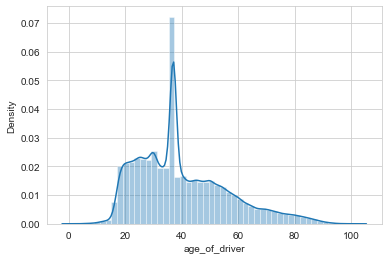

In [83]:
#age of driver plot
sns.distplot(vehicle_df['age_of_driver']);

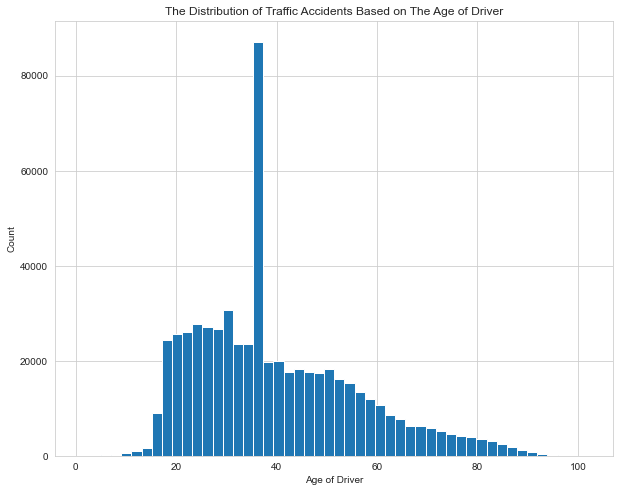

In [84]:
plt.figure(figsize=(10,8))

vehicle_df['age_of_driver'].hist(bins=50)
plt.xlabel('Age of Driver')
plt.ylabel('Count')
plt.title('The Distribution of Traffic Accidents Based on The Age of Driver')
plt.show()

In [85]:
vehicle_df['age_of_driver'].value_counts()

37.0     76503
30.0     18639
25.0     14558
26.0     13785
28.0     13465
         ...  
3.0          5
100.0        5
2.0          1
101.0        1
102.0        1
Name: age_of_driver, Length: 102, dtype: int64

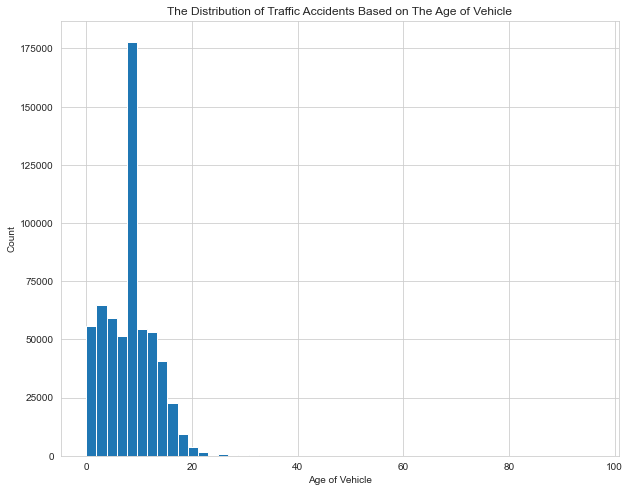

In [86]:
plt.figure(figsize=(10,8))

vehicle_df['age_of_vehicle'].hist(bins=50)
plt.xlabel('Age of Vehicle')
plt.ylabel('Count')
plt.title('The Distribution of Traffic Accidents Based on The Age of Vehicle')
plt.show()

In [87]:
vehicle_df['age_of_vehicle'].value_counts()

8.0     151648
1.0      36035
2.0      32976
3.0      31681
4.0      30673
         ...  
83.0         1
90.0         1
94.0         1
68.0         1
93.0         1
Name: age_of_vehicle, Length: 83, dtype: int64

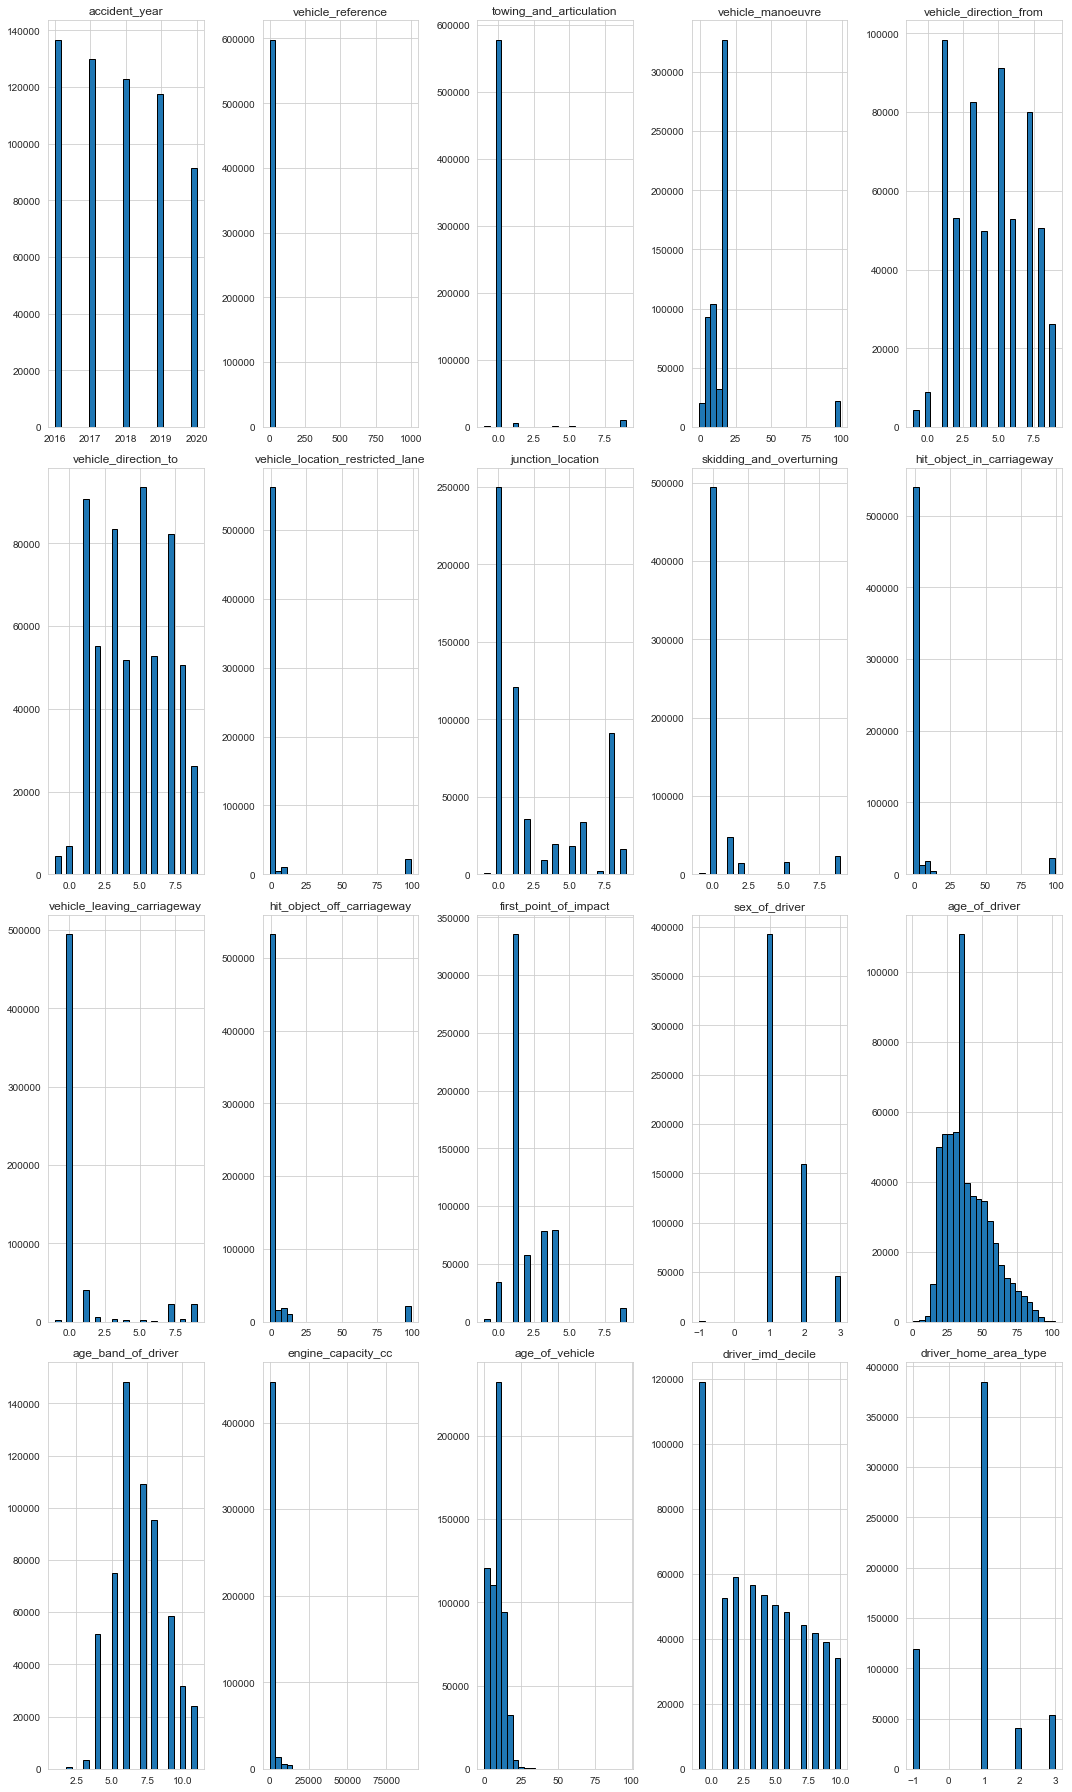

In [88]:
#view the distribution of the variables
vehicle_df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

## The casuality dataset

In [89]:
#read the third dataset
dfc=pd.read_csv("dft-road-casualty-statistics-casualty-last-5-years.csv")
dfc

accident_index  accident_year accident_reference  vehicle_reference  \
0       2016010000005           2016          010000005                  2   
1       2016010000006           2016          010000006                  1   
2       2016010000008           2016          010000008                  1   
3       2016010000016           2016          010000016                  1   
4       2016010000018           2016          010000018                  2   
...               ...            ...                ...                ...   
781711  2020991027064           2020          991027064                  2   
781712  2020991029573           2020          991029573                  1   
781713  2020991030297           2020          991030297                  2   
781714  2020991030900           2020          991030900                  2   
781715  2020991032575           2020          991032575                  1   

        casualty_reference  casualty_class  sex_of_casualty  age_of_casualty  \
0                        1               1                1               23   
1                        1               1                2               36   
2                        1               1                1               24   
3                        1               2                2               59   
4                        1               1                1               28   
...                    ...             ...              ...              ...   
781711                   1               1                1               11   
781712                   1               3                2               63   
781713                   1               1                1               38   
781714                   1               1                1               76   
781715                   1               3                1               48   

        age_band_of_casualty  casualty_severity  pedestrian_location  \
0                          5                  3                    0   
1                          7                  3                    0   
2                          5                  3                    0   
3                          9                  3                    0   
4                          6                  3                    0   
...                      ...                ...                  ...   
781711                     3                  2                    0   
781712                     9                  3                   10   
781713                     7                  2                    0   
781714                    11                  3                    0   
781715                     8                  3                    9   

        pedestrian_movement  car_passenger  bus_or_coach_passenger  \
0                         0              0                       0   
1                         0              0                       0   
2                         0              0                       0   
3                         0              0                       3   
4                         0              0                       0   
...                     ...            ...                     ...   
781711                    0              0                       0   
781712                    1              0                       0   
781713                    0              0                       0   
781714                    0              0                       0   
781715                    9              0                       0   

        pedestrian_road_maintenance_worker  casualty_type  \
0                                        0              2   
1                                        0              9   
2                                        0              9   
3                                        0             11   
4                                        0              1   
...                                  

In [90]:
#check it
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781716 entries, 0 to 781715
Data columns (total 18 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   accident_index                      781716 non-null  object
 1   accident_year                       781716 non-null  int64 
 2   accident_reference                  781716 non-null  object
 3   vehicle_reference                   781716 non-null  int64 
 4   casualty_reference                  781716 non-null  int64 
 5   casualty_class                      781716 non-null  int64 
 6   sex_of_casualty                     781716 non-null  int64 
 7   age_of_casualty                     781716 non-null  int64 
 8   age_band_of_casualty                781716 non-null  int64 
 9   casualty_severity                   781716 non-null  int64 
 10  pedestrian_location                 781716 non-null  int64 
 11  pedestrian_movement                 781

In [91]:
#check null values in this dataset
dfc.isnull().sum()

accident_index                        0
accident_year                         0
accident_reference                    0
vehicle_reference                     0
casualty_reference                    0
casualty_class                        0
sex_of_casualty                       0
age_of_casualty                       0
age_band_of_casualty                  0
casualty_severity                     0
pedestrian_location                   0
pedestrian_movement                   0
car_passenger                         0
bus_or_coach_passenger                0
pedestrian_road_maintenance_worker    0
casualty_type                         0
casualty_home_area_type               0
casualty_imd_decile                   0
dtype: int64

In [92]:
dfc.drop_duplicates(subset=['accident_index'],inplace=True)

In [93]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597973 entries, 0 to 781715
Data columns (total 18 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   accident_index                      597973 non-null  object
 1   accident_year                       597973 non-null  int64 
 2   accident_reference                  597973 non-null  object
 3   vehicle_reference                   597973 non-null  int64 
 4   casualty_reference                  597973 non-null  int64 
 5   casualty_class                      597973 non-null  int64 
 6   sex_of_casualty                     597973 non-null  int64 
 7   age_of_casualty                     597973 non-null  int64 
 8   age_band_of_casualty                597973 non-null  int64 
 9   casualty_severity                   597973 non-null  int64 
 10  pedestrian_location                 597973 non-null  int64 
 11  pedestrian_movement                 597

In [94]:
#check duplicates
n_duplicates =dfc.drop(labels=["accident_index"], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 0 duplicates in your database.


In [95]:
#  Extract column names of all features
columns_to_consider = dfc.drop(labels=["accident_index"], axis=1).columns

# Drop duplicates based on 'columns_to_consider'
casualty_df = dfc.drop_duplicates(subset=columns_to_consider, keep ='first')
casualty_df.shape

(597973, 18)

<AxesSubplot:>

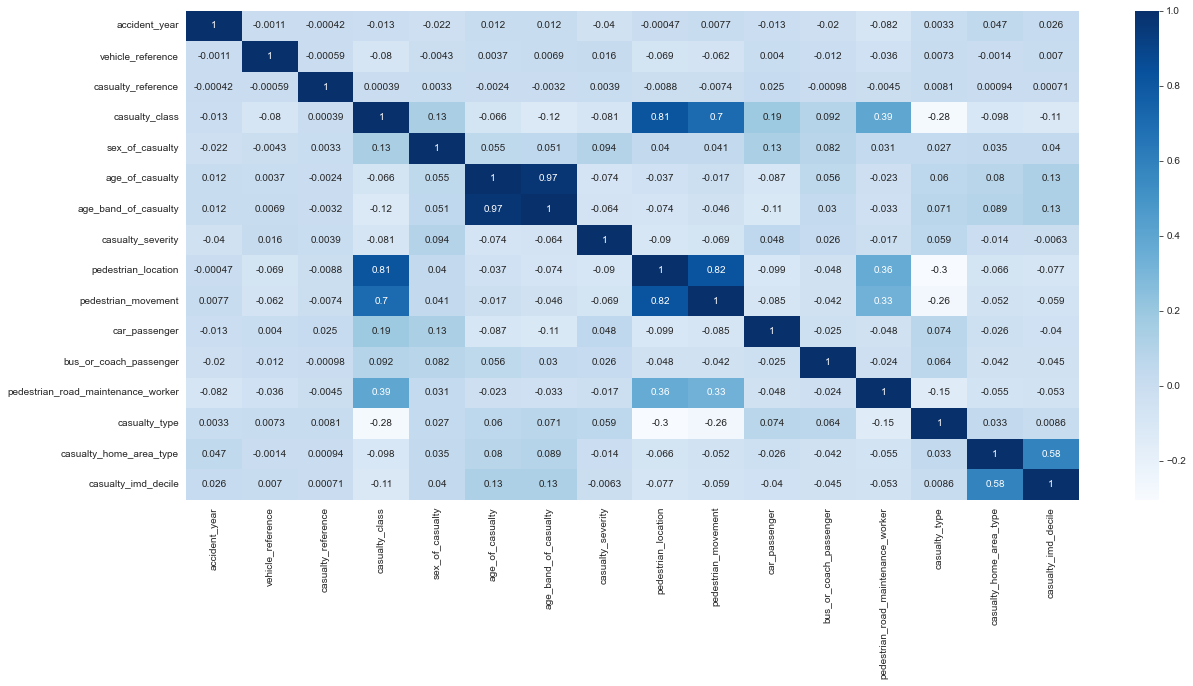

In [96]:
#check the correlation matrix
corr =  casualty_df.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr, annot = True,cmap="Blues")

In [97]:
# Replacing uknown values (-1) as NaN
casualty_df['sex_of_casualty'].replace(-1, np.NaN, inplace=True)
casualty_df['age_of_casualty'].replace(-1, np.NaN, inplace=True)
casualty_df['age_band_of_casualty'].replace(-1, np.NaN, inplace=True)
casualty_df['car_passenger'].replace(-1, np.NaN, inplace=True)
casualty_df['pedestrian_road_maintenance_worker'].replace(-1, np.NaN, inplace=True)
casualty_df['casualty_type'].replace(-1, np.NaN, inplace=True)
casualty_df['bus_or_coach_passenger'].replace(-1, np.NaN, inplace=True)

In [98]:
# Replacing NaN values as median and mode 
casualty_df[ 'sex_of_casualty'].fillna(casualty_df['sex_of_casualty'].mode(), inplace=True)
casualty_df['age_of_casualty'].fillna(casualty_df['age_of_casualty'].median(), inplace=True)
casualty_df['age_band_of_casualty'].fillna(casualty_df['age_band_of_casualty'].median(), inplace=True)
casualty_df[ 'car_passenger'].fillna(casualty_df['car_passenger'].mode(), inplace=True)
casualty_df['pedestrian_road_maintenance_worker'].fillna(casualty_df['pedestrian_road_maintenance_worker'].mode(), inplace=True)
casualty_df['bus_or_coach_passenger'].fillna(casualty_df['bus_or_coach_passenger'].mode(), inplace=True)
casualty_df['casualty_type'].fillna(casualty_df['casualty_type'].median(), inplace=True)

In [99]:
casualty_df.casualty_class.value_counts(normalize=True)

1    0.733983
3    0.166730
2    0.099287
Name: casualty_class, dtype: float64

In [100]:
casualty_df.casualty_class = casualty_df.casualty_class.replace([1,2,3], 
                               ['Driver or rider', 'Passenger','Pedestrian'])
casualty_df.casualty_class.value_counts(normalize=True)

Driver or rider    0.733983
Pedestrian         0.166730
Passenger          0.099287
Name: casualty_class, dtype: float64

In [101]:
casualty_df.casualty_severity.value_counts(normalize=True)

3    0.823512
2    0.164879
1    0.011609
Name: casualty_severity, dtype: float64

In [102]:
#replace causalty severity into right words
casualty_df.casualty_severity = casualty_df.casualty_severity.replace([1,2,3], 
                               ['Fatal', 'Serious','Slight'])
casualty_df.casualty_severity.value_counts(normalize=True)

Slight     0.823512
Serious    0.164879
Fatal      0.011609
Name: casualty_severity, dtype: float64

## Merge three datasets together

In [103]:
#Check Unique values for the common feature
print(accident_df['accident_index'].nunique())
print(vehicle_df['accident_index'].nunique())
print(casualty_df['accident_index'].nunique())

597973
597975
597973


In [104]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597975 entries, 0 to 1101590
Data columns (total 27 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   accident_index                    597975 non-null  object 
 1   accident_year                     597975 non-null  int64  
 2   accident_reference                597975 non-null  object 
 3   vehicle_reference                 597975 non-null  int64  
 4   vehicle_type                      597975 non-null  object 
 5   towing_and_articulation           597975 non-null  int64  
 6   vehicle_manoeuvre                 597975 non-null  int64  
 7   vehicle_direction_from            597975 non-null  int64  
 8   vehicle_direction_to              597975 non-null  int64  
 9   vehicle_location_restricted_lane  597975 non-null  int64  
 10  junction_location                 597975 non-null  int64  
 11  skidding_and_overturning          597975 non-null  

In [105]:
accident_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 597973 entries, 0 to 597972
Data columns (total 36 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               597973 non-null  object        
 1   accident_year                                597973 non-null  int64         
 2   accident_reference                           597973 non-null  object        
 3   location_easting_osgr                        597850 non-null  float64       
 4   location_northing_osgr                       597850 non-null  float64       
 5   longitude                                    597973 non-null  float64       
 6   latitude                                     597973 non-null  float64       
 7   police_force                                 597973 non-null  int64         
 8   accident_severity                            597973 non-null  ob

In [106]:
# Outer join casualty and vehicle datasets
merged_cas_veh = pd.merge(casualty_df, vehicle_df, 
                        how="outer", 
                        on=('accident_index'))

In [107]:
# inner join accident dataset with casualty and vehicle dataset
df = pd.merge(accident_df, merged_cas_veh, 
                       how="inner", 
                       on='accident_index')

In [108]:
# drop duplicated rows
df.drop_duplicates(keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561943 entries, 0 to 561942
Data columns (total 79 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               561943 non-null  object        
 1   accident_year                                561943 non-null  int64         
 2   accident_reference                           561943 non-null  object        
 3   location_easting_osgr                        561822 non-null  float64       
 4   location_northing_osgr                       561822 non-null  float64       
 5   longitude                                    561943 non-null  float64       
 6   latitude                                     561943 non-null  float64       
 7   police_force                                 561943 non-null  int64         
 8   accident_severity                            561943 non-null  ob

In [109]:
df.shape

(561943, 79)

In [110]:
df['accident_index'].nunique()

561943

In [111]:
def Check_null(data):
    '''
    This function calculates the number of missing values in columns of a dataset. 
    It takes a dataframe as its only parameter. 
    It is implemented using the pandas object method, isnull(). The method method returns a DataFrame object
    where all the values are replaced with a Boolean value True for NULL values, and otherwise False.
    The rest of the function sums up the count of null values and appends them to variable (miss) which the function returns'''
    
    miss = data.isnull().sum() # Compute the percentage and assign it to a variable
    return miss # Return variable

In [112]:
Check_null(df)

accident_index                 0
accident_year                  0
accident_reference             0
location_easting_osgr        121
location_northing_osgr       121
                           ...  
propulsion_code           149114
age_of_vehicle             39488
generic_make_model         39488
driver_imd_decile          39488
driver_home_area_type      39488
Length: 79, dtype: int64

In [113]:
def fill_missing(data, use_method='ffill', way='dataframe', column=None):
    '''
        Function fills missing values in a dataset or individual column, witha scalar value using multiple methods. 
        It accepts the following parameters; 
        a dataframe, 
        a method to fill the missing values- set to ffill by default, 
        way - data structure - dataframe or dataframe column.
        column- column name - set to none by default.

        It applies pandas fillna methods; ffill = forward fill,  backfill == backward fill 
        and other statistically significant values including;
        The median score
        The mean score
        The modal value 
    '''
    if way == 'dataframe': # Condition to check way as dataframe
        if use_method == 'ffill': # Condition to check for use method as forward fill
            data.fillna(method='ffill', inplace = True) # forward fill the missing value
            return data.isnull().sum() # Return the sum of missing values
        elif use_method == 'backfill': # Condition to check for use method as backward fill
            data.fillna(method='backfill', inplace = True) # backward fill the missing value
            return data.isnull().sum() # Return the sum of missing values
        else :
            data.fillna(use_method, inplace = True) # use impute to fill the missing value
            return data.isnull().sum() # Return the sum of missing values
    elif way == 'feature': # Condition to check way as feature
        if use_method == 'ffill': # Condition to check for use method as forward fill
            data[column].fillna(method='ffill', inplace = True) # forward fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'backfill': # Condition to check for use method as backward fill
            data[column].fillna(method='backfill', inplace = True) # backward fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'median': # Condition to check for use method as median
            data[column].fillna(data[column].median(), inplace = True) # Use median to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'mean': # Condition to check for use method as mean
            data[column].fillna(data[column].mean(), inplace = True) # Use mean to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'mode': # Condition to check for use method as mode
            data[column].fillna(data[column].mode()[0], inplace = True) # Use mode to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        else :
            data[column].fillna(use_method, inplace = True) # use impute to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values

In [114]:
fill_missing(df) #For forward fill
fill_missing(df, 'backfill') #For backward fill

accident_index            0
accident_year             0
accident_reference        0
location_easting_osgr     0
location_northing_osgr    0
                         ..
propulsion_code           0
age_of_vehicle            0
generic_make_model        0
driver_imd_decile         0
driver_home_area_type     0
Length: 79, dtype: int64

In [115]:
Check_null(df)

accident_index            0
accident_year             0
accident_reference        0
location_easting_osgr     0
location_northing_osgr    0
                         ..
propulsion_code           0
age_of_vehicle            0
generic_make_model        0
driver_imd_decile         0
driver_home_area_type     0
Length: 79, dtype: int64

In [116]:
#cleaned and merged dataset saved in a new csv file
df.to_csv('merged_dataset_new.csv',index=False)

In [117]:
merged_dataset1 = pd.read_csv("merged_dataset_new.csv")

In [118]:
merged_dataset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561943 entries, 0 to 561942
Data columns (total 79 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               561943 non-null  object 
 1   accident_year                                561943 non-null  int64  
 2   accident_reference                           561943 non-null  object 
 3   location_easting_osgr                        561943 non-null  float64
 4   location_northing_osgr                       561943 non-null  float64
 5   longitude                                    561943 non-null  float64
 6   latitude                                     561943 non-null  float64
 7   police_force                                 561943 non-null  int64  
 8   accident_severity                            561943 non-null  object 
 9   number_of_vehicles                           561943 non-nul

In [119]:
len(merged_dataset1.accident_index.unique())

561943

In [120]:
merged_dataset1 = merged_dataset1.reset_index()

## Narrow down to only London area

In [121]:
import geopandas as gpd

In [122]:
london_boundary = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Ward.shp')

<AxesSubplot:>

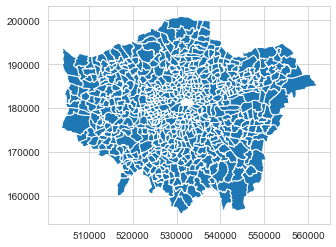

In [123]:
london_boundary.plot()

<AxesSubplot:>

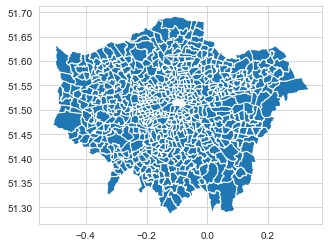

In [124]:
london_boundary = london_boundary.to_crs(epsg=4326)
london_boundary.plot()

In [125]:
from shapely.geometry import Point

In [126]:
#narrow down the whole UK traffic accidents into only London area by matching it with the London shapefile
merge_point = gpd.GeoDataFrame([[merged_dataset1['index'][i],Point(merged_dataset1['longitude'][i],merged_dataset1['latitude'][i])] for i in range(len(merged_dataset1))],
                columns=['index','geometry'],crs='epsg:4326'
                )

In [127]:
merge_join = gpd.sjoin(merge_point,london_boundary,op='within')
merge_join.head()

index                   geometry  index_right    NAME   GSS_CODE  \
0         0  POINT (-0.27932 51.58475)          182  Kenton  E05000093   
1063   1063  POINT (-0.31401 51.58364)          182  Kenton  E05000093   
1120   1120  POINT (-0.28220 51.58498)          182  Kenton  E05000093   
1202   1202  POINT (-0.30683 51.58650)          182  Kenton  E05000093   
3411   3411  POINT (-0.30756 51.58615)          182  Kenton  E05000093   

      HECTARES  NONLD_AREA  LB_GSS_CD BOROUGH  POLY_ID  
0      224.315         0.0  E09000005   Brent   116946  
1063   224.315         0.0  E09000005   Brent   116946  
1120   224.315         0.0  E09000005   Brent   116946  
1202   224.315         0.0  E09000005   Brent   116946  
3411   224.315         0.0  E09000005   Brent   116946

In [128]:
merged_dataset2 = pd.merge(merge_join,merged_dataset1,on='index')

<AxesSubplot:>

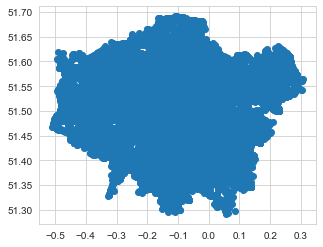

In [129]:
merged_dataset2.plot()

<AxesSubplot:>

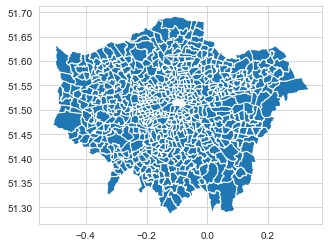

In [130]:
#compare it with the original shapefile
london_boundary.plot()

In [131]:
#save it to a new csv file for further analysis
merged_dataset2.to_csv("London_traffic_accidents.csv", index=False)

In [132]:
merged_dataset2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 106938 entries, 0 to 106937
Data columns (total 89 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   index                                        106938 non-null  int64   
 1   geometry                                     106938 non-null  geometry
 2   index_right                                  106938 non-null  int64   
 3   NAME                                         106938 non-null  object  
 4   GSS_CODE                                     106938 non-null  object  
 5   HECTARES                                     106938 non-null  float64 
 6   NONLD_AREA                                   106938 non-null  float64 
 7   LB_GSS_CD                                    106938 non-null  object  
 8   BOROUGH                                      106938 non-null  object  
 9   POLY_ID                                 

In [133]:
#keep relevant columns
cols_to_keep = ['accident_year', 'converted_time', 'day_of_week', 'number_of_vehicles', 'date',
               'number_of_casualties', 'accident_severity', 'longitude', 'latitude']
df1 = merged_dataset2[cols_to_keep]

In [134]:
df1.shape

(106938, 9)

In [135]:
#convert Date column into datetime format
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')
#extract month and year
df1['YearMonth'] = df1['date'].map(lambda x: 100*x.year + x.month).astype(str)

In [136]:
df1_table = df1.groupby(['YearMonth'])['number_of_casualties', 
                                       'number_of_vehicles'].sum().reset_index()

In [137]:
df1_table.head()

YearMonth  number_of_casualties  number_of_vehicles
0    201601                  2454                3530
1    201602                  2334                3414
2    201603                  2383                3531
3    201604                  2376                3578
4    201605                  2670                3973

Text(0.5, 1.0, 'London Traffic Casualties (2016-2020)')

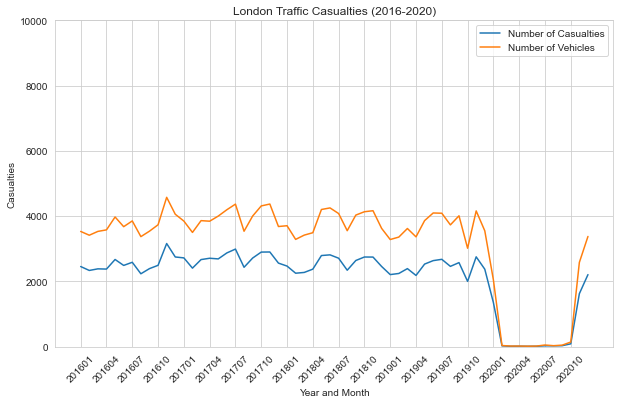

In [138]:
#visualize results
ax = df1_table.plot(figsize=(10,6),
                    y=['number_of_casualties', 'number_of_vehicles'],
                    xticks=df1_table.index[0::3], rot=45)
ax.set_xticklabels(df1_table['YearMonth'][0::3])
ax.legend(["Number of Casualties", "Number of Vehicles"])
plt.ylim([0,10000])
plt.ylabel('Casualties')
plt.xlabel('Year and Month')
plt.title('London Traffic Casualties (2016-2020)')

In [139]:
df2 = df1[cols_to_keep]
df2['Date'] = pd.to_datetime(df2['date'], errors='coerce')
df2['YearMonth'] = df2['Date'].map(lambda x: 100*x.year + x.month).astype(str)
df2_table = df2.groupby(['YearMonth'])['number_of_casualties', 
                                       'number_of_vehicles'].sum().reset_index()

In [140]:
df_table = df2_table.sort_values('YearMonth').reset_index()

In [141]:
df_table.loc[df_table['number_of_vehicles'].idxmax()]

index                       10
YearMonth               201611
number_of_casualties      3159
number_of_vehicles        4576
Name: 10, dtype: object

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
sns.set_style('darkgrid')
plt.style.use('seaborn-poster')
%matplotlib inline

In [143]:
london = {'latitude': 51.504873, 'longitude': 0.049368}


In [155]:
#select only the worst month
df_map = df2[df2['YearMonth'] == '201611']

	

m = folium.Map(location=[london['latitude'], london['longitude']], tiles='stamentoner')
	
folium.TileLayer('openstreetmap').add_to(m)
#plot points on map
for idx, row in df_map.iterrows():
    folium.CircleMarker([row.loc['latitude'], row.loc['longitude']], 
                        radius=row['number_of_casualties'], 
                        fill=True, color="blue", opacity=0.4
                       ).add_to(m)
m

In [156]:
df_map.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2649 entries, 0 to 106910
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   accident_year         2649 non-null   int64         
 1   converted_time        2649 non-null   int64         
 2   day_of_week           2649 non-null   object        
 3   number_of_vehicles    2649 non-null   int64         
 4   date                  2649 non-null   datetime64[ns]
 5   number_of_casualties  2649 non-null   int64         
 6   accident_severity     2649 non-null   object        
 7   longitude             2649 non-null   float64       
 8   latitude              2649 non-null   float64       
 9   Date                  2649 non-null   datetime64[ns]
 10  YearMonth             2649 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)
memory usage: 248.3+ KB


In [154]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from pyproj import crs
import geopandas as gpd
import matplotlib.pyplot as plt
import folium


In [158]:
map_clusters = folium.Map(location=[51.504873, 0.049368], zoom_start=4, control_scale=True)
# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
markers_colors = []
for lat, lng in zip(df_map['latitude'], df_map['longitude']):
        folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=1,
        #popup=label,
        fill=True,
        fill_opacity=0.9).add_to(map_clusters)

map_clusters

In [160]:
df_map = df2[df2['YearMonth'] == '202011']

map_clusters = folium.Map(location=[51.504873, 0.049368], zoom_start=4, control_scale=True)
# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
markers_colors = []
for lat, lng in zip(df_map['latitude'], df_map['longitude']):
        folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=1,
        #popup=label,
        fill=True,
        fill_opacity=0.9).add_to(map_clusters)

map_clusters

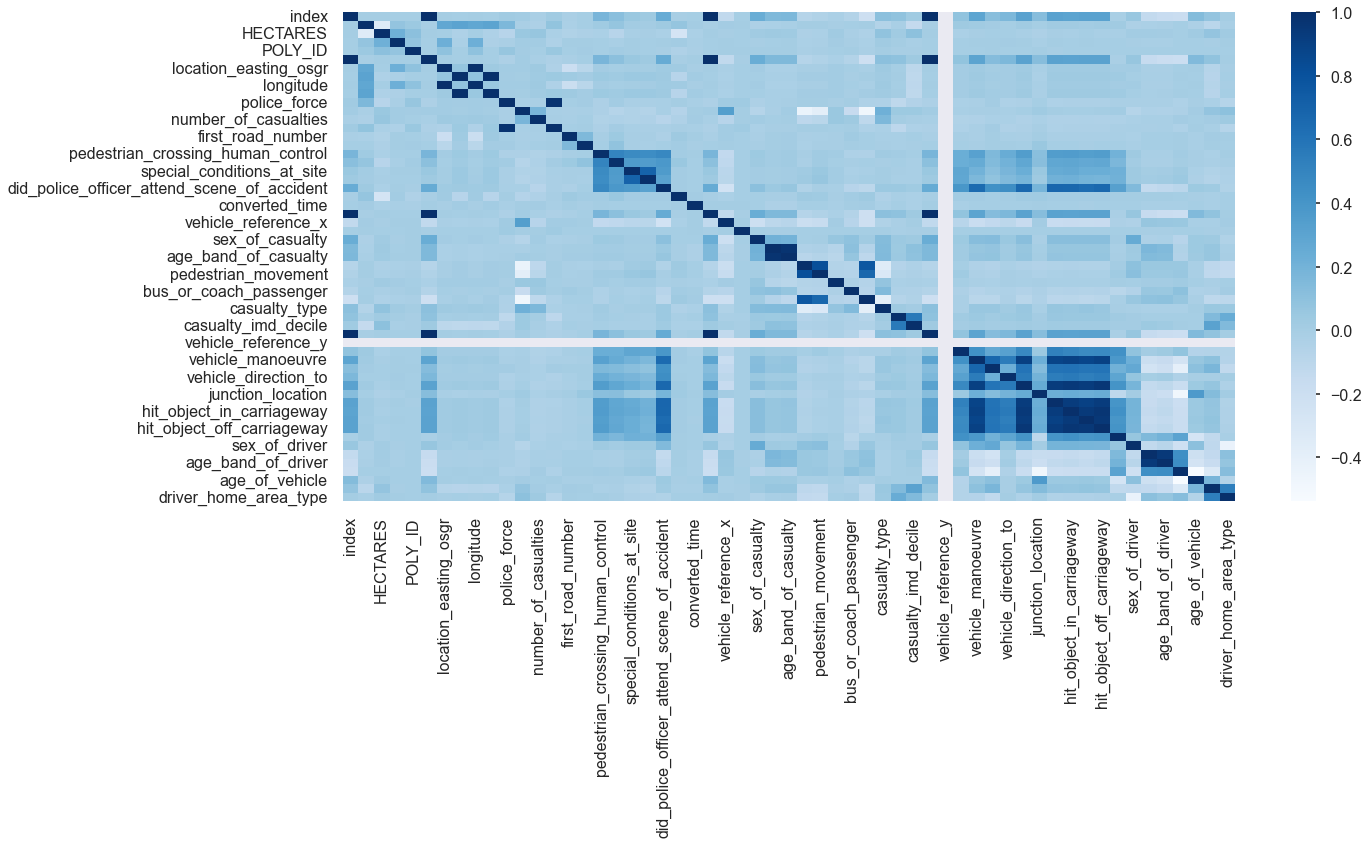

In [146]:
corr =  merged_dataset2.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr,cmap="Blues")
plt.savefig("correlation_matrix.png", dpi=600)

In [147]:
merged_dataset2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 106938 entries, 0 to 106937
Data columns (total 89 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   index                                        106938 non-null  int64   
 1   geometry                                     106938 non-null  geometry
 2   index_right                                  106938 non-null  int64   
 3   NAME                                         106938 non-null  object  
 4   GSS_CODE                                     106938 non-null  object  
 5   HECTARES                                     106938 non-null  float64 
 6   NONLD_AREA                                   106938 non-null  float64 
 7   LB_GSS_CD                                    106938 non-null  object  
 8   BOROUGH                                      106938 non-null  object  
 9   POLY_ID                                 

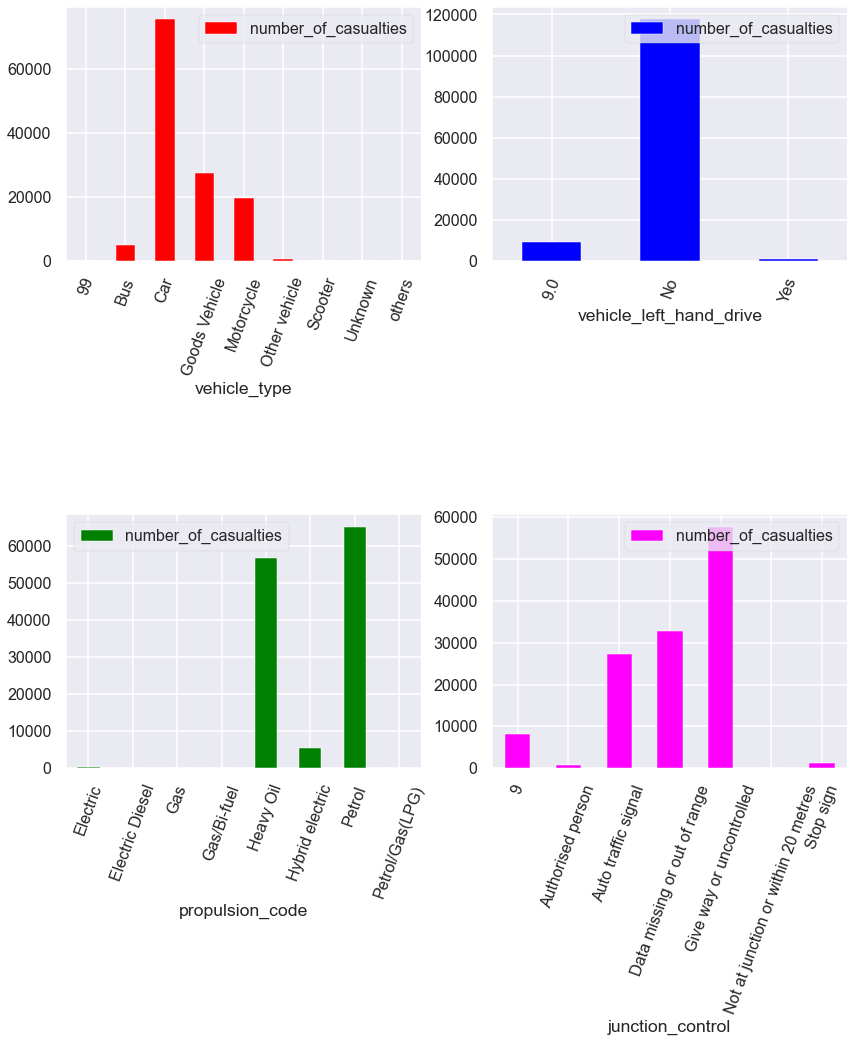

In [148]:
#CASUALTIES
f,ax= plt.subplots(2,2,figsize=(14,14))
f= merged_dataset2.groupby(['vehicle_type']).sum()['number_of_casualties'].to_frame().plot(kind='bar', cmap = 'autumn',ax=ax[0,0], rot = 70)
f= merged_dataset2.groupby(['vehicle_left_hand_drive']).sum()['number_of_casualties'].to_frame().plot(kind='bar', cmap = 'winter',ax=ax[0,1], rot = 70)
f= merged_dataset2.groupby(['propulsion_code']).sum()['number_of_casualties'].to_frame().plot(kind='bar', cmap = 'ocean', ax=ax[1,0], rot = 70)
f = merged_dataset2.groupby(['junction_control']).sum()['number_of_casualties'].to_frame().plot(kind='bar', cmap = 'spring', ax=ax[1,1], rot = 70)

plt.subplots_adjust( hspace = 1.0 )

In [149]:
#defining function for plot conditioned on casualty class
def casualty_severity_category_plot(col, title='Proportion of casualty by severity', figsize=(10,5)):
    """Plots a bar chart of the proportions of the specified column for each Casualty severity category"""
    merged_dataset2.groupby('casualty_class')[col].value_counts(normalize=True).unstack().sort_index(ascending=False).plot(figsize=figsize, kind='bar')
    plt.title(title)
    plt.xlabel('casualty severity')
    plt.ylabel('Proportion of accidents')
    plt.xticks(rotation=0)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

<AxesSubplot:>

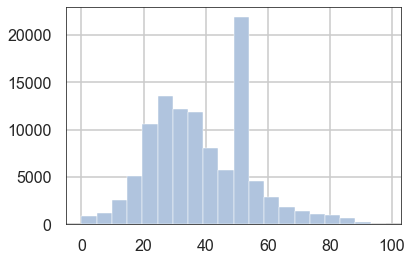

In [150]:
sns.set_style('white')
merged_dataset2.age_of_casualty.hist(bins=20, color='lightsteelblue')

<AxesSubplot:>

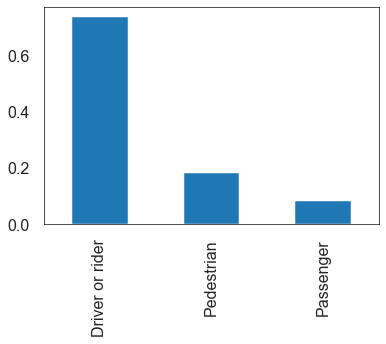

In [151]:
#calculate the percentage of each cas category.
merged_dataset2.casualty_class.value_counts(normalize=True)

#plot the pie chart of education categories
merged_dataset2.casualty_class.value_counts(normalize=True).plot.bar()

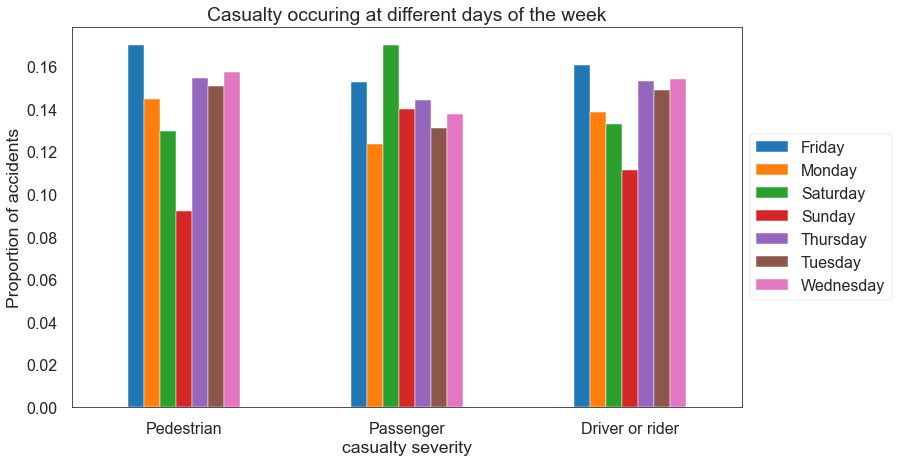

In [152]:
casualty_severity_category_plot('day_of_week', figsize=(12,7), title='Casualty occuring at different days of the week')

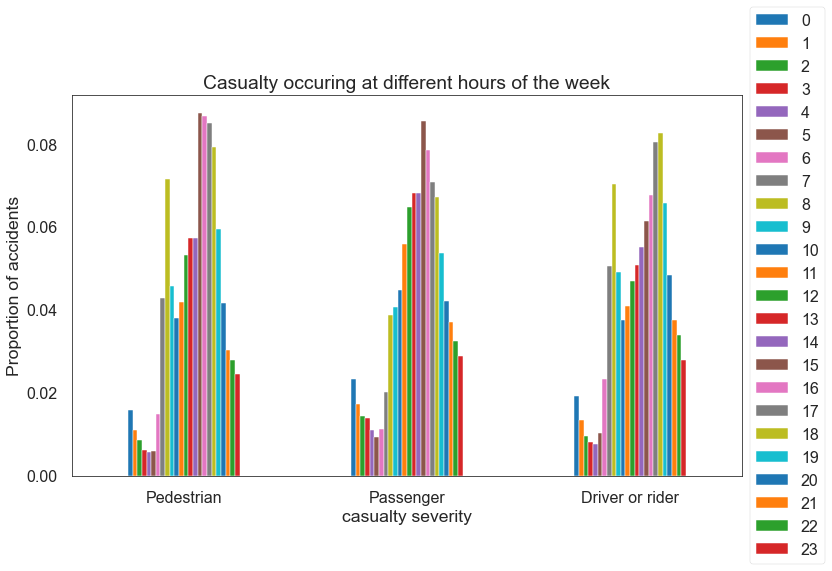

In [153]:
casualty_severity_category_plot('converted_time', figsize=(12,7), title='Casualty occuring at different hours of the week')